In [2]:
# plotter.py copy and pasted in

In [3]:
import os
print(os.getcwd())

C:\Users\Saara\Documents\3rd year phys\project


In [4]:
#code to make sure all filed from zip are in properly 
import zipfile

# Specify the path to your ZIP file and the destination folder
zip_file_path = 'g2InputFiles.zip'
destination_folder = 'g2s'

# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print("Files extracted successfully!")
# so now all files are in there

Files extracted successfully!


In [5]:
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.pyplot as plt
import imageio
from matplotlib.cm import ScalarMappable
import pickle
import sys
from matplotlib.lines import Line2D

#https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html
#custom color map: set desired map (either grainbow or viridis here) to the newcolors
levels = 200
grainbow = cm.get_cmap('gist_rainbow', levels)
viridis = cm.get_cmap('viridis', levels)
newcolors = viridis(np.linspace(0, 1, levels))

#uncomment to add white when 0
#white = np.array([1, 1, 1, 1])
#newcolors[:2, :] = white
newcmp = ListedColormap(newcolors)
chosencmap = grainbow

outFolder = "Plots/"
nPhases = 29
withEDM = False
#load in pkled decay probs, at chosen phase index degrees
#phase index goes from 0-29 and cover 0 -> 2pi
#so for example phase index 7 is at phi = (7/29)*2pi ~ pi/2

phaseIndex = 0
withEDM = True
#phaseval is i values from 0 - 28 in a linspace array
phaseval = np.linspace(0, 28, 29)
#changing phaseval to mean ALPHA not i.
phaseval = ((2*np.pi)/29)*phaseval
print('phaseval is' , phaseval)
# saara bit
inFolder = "g2s/user/jprice/www/Project2024-25/InputFiles"
filename = "G2"
if withEDM:
    fn = f"{inFolder}/{filename}_{phaseIndex:02d}_withEDM.pkl"
    
#pick your lambda slices, can just use [0.6] for single plot,
#also make stems for fancy labels later on
#sliceLs = [0.2 + i*(0.01) for i in range(0,73)]
sliceLs = [0.6]
lamStem = r'$\lambda$'
momStem = r'$p_{e^{+}}$'
phiStem = r'$\phi$'
piStem = r'$\pi$'

sliceLs = np.zeros(74)                                   #SAARA 
for n in range(0, 73):
    sliceLs[n] = 0.2 + (0.01*n)
    
sliceLs = [0.6]

# uses each EDM file and gets an array of average angles: 29 in the array, for each i value going from 0 - 28
# noEDM
avgangles0 = np.zeros(29)
Nvals0 = np.zeros(29)
Nd0 = np.zeros(29)
Nu0 = np.zeros(29)
Asym0 = np.zeros(29)
Asymerr0 = np.zeros(29)
standdev0 = np.zeros(29)

avgangles1 = np.zeros(29)
standdev1 = np.zeros(29)
Nvals1 = np.zeros(29)
Nd1 = np.zeros(29)
Nu1 = np.zeros(29)
Asym1 = np.zeros(29)
Asymerr1 = np.zeros(29)

standdev = [standdev0, standdev1]
avgangles = [avgangles0, avgangles1]
Nvals = [Nvals0, Nvals1]
Nd = [Nd0, Nd1]
Nu = [Nu0, Nu1]
Asym = [Asym0, Asym1]
Asymerr =  [Asymerr0, Asymerr1]
ntotal = 1 # number of decays? multiplying up all my probability dependent valuesb

#for plotting at this particular lambda
iplot = 7
thetaplot = [[],[]]
zplot = [[],[]]


i = 0
ialpha = 0
for filename in os.listdir(inFolder):
    file_path = os.path.join(inFolder, filename)
    edmIndex = 0
    if os.path.isfile(file_path) and "withEDM" in filename:
        edmIndex = 1
    ialpha = int((filename.split('_withEDM')[0]).split('_')[-1].split('.')[0])
    
    # print(f"Processing report file: {filename}")
    with open(file_path, "rb") as f:
        X,Y,Z = pickle.load(f)
        l = X[0]
        theta = Y[:,1] 
        dlambda = l[1]-l[0]
        dtheta = theta[1]-theta[0]
        for sliceL in sliceLs:
            lindex = np.argmin(np.abs(sliceL-l))
            z = Z[:,lindex].transpose()
            
            #save for plot
            if ialpha == iplot:
                thetaplot[edmIndex] = theta
                zplot[edmIndex] = z
            
            avgtheta = np.sum((z)*theta) / np.sum(z)
            variance = (np.sum((z)*theta**2) / np.sum(z)) - avgtheta**2
            # print("Average theta value for {filename} is:", avgtheta, 'i:', i)
            avgangles[edmIndex][i] = avgtheta
            standdev[edmIndex][i] = np.sqrt(variance)
            # finding the area of the bins over 29 bins
            Nval = np.sum(z)*dtheta*dlambda
            Nvals[edmIndex][i] = ntotal*Nval
            # finding the asymmetry. asymmetry is defined after the loop ends.
            down = np.sum(z[theta<0])
            Nd[edmIndex][i] = ntotal*down
            up = np.sum(z[theta>0])
            Nu[edmIndex][i] = ntotal*up
            # finding the standard deviation
                
                
        if (edmIndex == 1):
            i += 1
    
for n in range(29):
    for j in [0,1]:
        Asym[j][n] = (Nu[j][n] - Nd[j][n])/(Nu[j][n] + Nd[j][n])
        #print(n, Nvals[n], Nu[n], Nd[n], (Nu[n]+Nd[n])*dlambda*dtheta)
        #Asymerr[j][n] = np.sqrt((((2*Nd[j][n])/(Nu[j][n]+Nd[j][n]))*(np.sqrt(Nu[j][n])))**2 + 
                                #(((2*Nu[j][n])/((Nu[j][n]+Nd[j][n])))*(np.sqrt(Nd[j][n])))**2)
        Asymerr[j][n] = np.sqrt((1-Asym[j][n]**2)/Nvals[j][n]) # more concise version of above line!
        
# ntotalarr = np.ones_like(Asym0)
# ntotalarr = ntotalarr
# print(ntotalarr)

# Asym0 = ntotalarr*Asym0
# Asym1 = ntotalarr*Asym1
# print('Asym is ', Asym)
# print('Asymerr is ', Asymerr)
# print('Nu is ', Nu)
# print('Nd is ', Nd)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_14632\3278998797.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  grainbow = cm.get_cmap('gist_rainbow', levels)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_14632\3278998797.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', levels)


phaseval is [0.         0.21666156 0.43332312 0.64998469 0.86664625 1.08330781
 1.29996937 1.51663094 1.7332925  1.94995406 2.16661562 2.38327719
 2.59993875 2.81660031 3.03326187 3.24992343 3.466585   3.68324656
 3.89990812 4.11656968 4.33323125 4.54989281 4.76655437 4.98321593
 5.1998775  5.41653906 5.63320062 5.84986218 6.06652374]


23.40031075503359


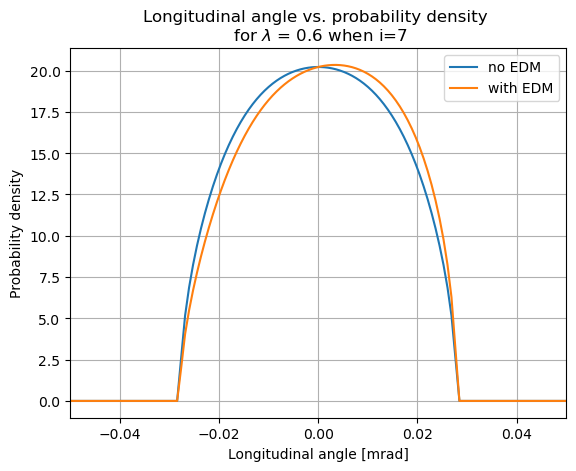

In [6]:
sliceLs = [0.6]
#phaseIndex = 0
plt.plot(thetaplot[0], zplot[0], label='no EDM')
plt.plot(thetaplot[1], zplot[1], label='with EDM')
plt.ylabel('Probability density')
plt.xlabel('Longitudinal angle [mrad]')
plt.legend()
plt.title(f'Longitudinal angle vs. probability density \n for $\lambda$ = 0.6 when i={iplot}')
plt.grid()
#print(theta)
plt.xlim(-0.05, 0.05)
print(np.max(z))

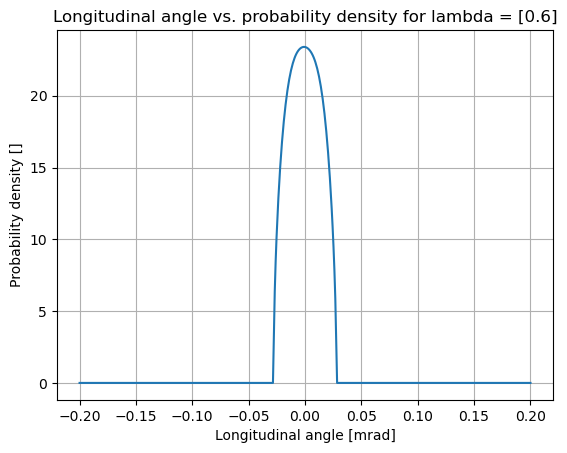

In [7]:
plt.clf()
sliceLs = [0.6]
phaseIndex = 20
plt.plot(theta, z)
plt.ylabel('Probability density []')
plt.xlabel('Longitudinal angle [mrad]')
plt.title(f'Longitudinal angle vs. probability density for lambda = {sliceLs}')
plt.grid()
#plt.xlim(-0.05, 0.05)

[ 0.00000000e+00 -5.76795556e-17 -1.12757026e-16 -1.62847166e-16
 -2.04914211e-16 -2.38090797e-16 -2.59558000e-16 -2.68231617e-16
 -2.65195851e-16 -2.49800181e-16 -2.22695126e-16 -1.84964891e-16
 -1.38344197e-16 -8.56519716e-17 -2.90566182e-17  2.90566182e-17
  8.58688121e-17  1.38344197e-16  1.84964891e-16  2.22478286e-16
  2.49583340e-16  2.65846373e-16  2.68882139e-16  2.58907479e-16
  2.37440276e-16  2.04914211e-16  1.62196645e-16  1.12973866e-16
  5.76795556e-17]


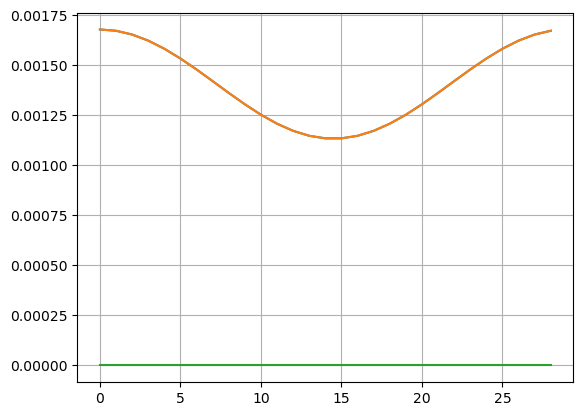

In [8]:
plt.plot(Nvals[0])
plt.plot(Nvals[1])
plt.grid()
plt.plot(Nvals[1]-Nvals[0])
print(Nvals[1]-Nvals[0])

0.0011253210240180676 0.00013851724934045315


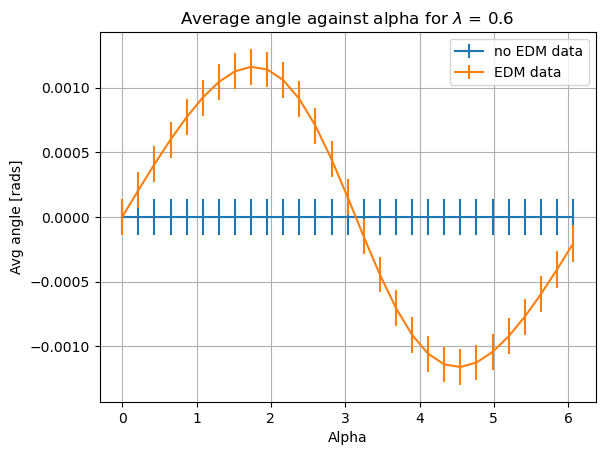

In [9]:
selectanNvalue = 1e4
plt.errorbar(phaseval, avgangles[0], xerr=0, yerr=standdev[0]/np.sqrt(selectanNvalue),
             label='no EDM data')
plt.errorbar(phaseval, avgangles[1], xerr=0, yerr=standdev[1]/np.sqrt(selectanNvalue),
         label='EDM data')
plt.xlabel('Alpha')
plt.ylabel('Avg angle [rads]')
plt.title(f'Average angle against alpha for $\lambda$ = 0.6')
plt.grid()
plt.legend()
#plt.xlim(0,35)
#print(avgangles)
print(avgangles[1][7], standdev[1][7]/100)

29


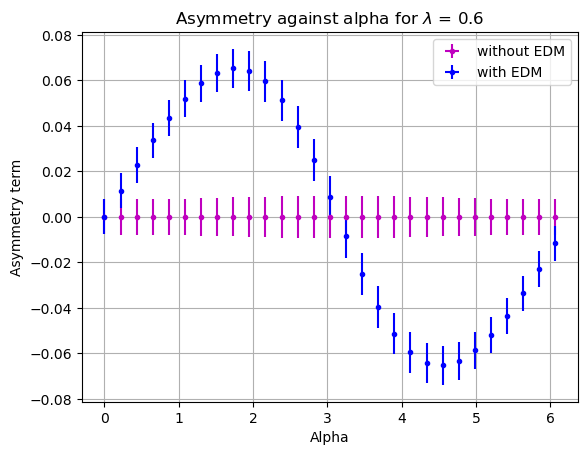

In [10]:
alpha = phaseval #2*np.pi*phaseval/29

#for plotting, pick number of decays
nplot = 1E7
# print(alpha)
# print(Asym0)
# print(Asym1)
# print(Asymerr0)
# print(Asymerr1)
plt.errorbar(alpha, Asym0, xerr=np.zeros_like(alpha), yerr=Asymerr0*(1/np.sqrt(nplot)), 
             linestyle='', marker = '.' , color = 'm', label = 'without EDM')
plt.errorbar(alpha, Asym1, xerr=np.zeros_like(alpha), yerr=Asymerr1*(1/np.sqrt(nplot)), 
             linestyle='', marker = '.', color = 'b', label='with EDM' )
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Asymmetry term')
plt.title(f'Asymmetry against alpha for $\lambda$ = 0.6')
plt.grid()
print(len(Asym0))

In [1]:
# def
Ns = np.array([(1e2, 1e3, 1e4, 1e5, 1e6), (1e2, 1e3, 1e4, 1e5, 1e6)])
# dA = np.sqrt((1-Asym[j][n]**2)/Nvals[j][n])
randomvals1, randomvals2 = np.zeros(29), np.zeros(29)
randomvals = [randomvals1, randomvals2]
chisq1, chisq2 = np.zeros(29), np.zeros(29)
chisq = [chisq1, chisq2]
for j in range(len(Asym)):
    for n in range(len(Asym[j])):    
        randomvals[j][n] = np.random.normal(Asym[j][n], Asymerr[j][n]*(1/np.sqrt(nplot)))
        chisq[j][n] = ((randomvals[j][n] - Asym[j][n])**2)/Asymerr[j][n]*(1/np.sqrt(nplot))

# def Ndepfunc(N): # defining this N dependent function: as we change number of events, what's going to happen?
#     for i in range(len(Nu)):
#         A[j][n] = (Nu[j][n] - Nd[j][n])/(Nu[j][n] + Nd[j][n]) # A is independent of N...
#         Aerr[j][n] = np.sqrt((1-A[j][n]**2)/Ns[j][n])
#         return A, Aerr

plt.errorbar(alpha, Asym1, xerr=np.zeros_like(alpha), yerr=Asymerr1*(1/np.sqrt(nplot)), 
             linestyle='', marker = '.', color = 'b', label='with EDM' )
plt.plot(phaseval, randomvals2, marker='o', linestyle='')
plt.grid()
plt.show()

#plt.hist(randomvals2-Asym1)
#plt.show()

# creating function to randomise Asym values
randomAsymerr1, randomAsymerr2 = np.zeros(29), np.zeros(29)
randomAsym1, randomAsym2 = np.zeros(29), np.zeros(29)
randomAsymerr = [randomAsymerr1, randomAsymerr2]
randomAsym = [randomAsym1, randomAsym2]

def randomiseA(Anew, selectNvalue):
    # creating function to randomise Asym values
    randomAsymerr1, randomAsymerr2 = np.zeros(29), np.zeros(29)
    randomAsym1, randomAsym2 = np.zeros(29), np.zeros(29)
    randomAsymerr = [randomAsymerr1, randomAsymerr2]
    randomAsym = [randomAsym1, randomAsym2]
    tmpAsymerr1, tmpAsymerr2 = np.zeros(29), np.zeros(29)
    tmpAsymerr = [tmpAsymerr1, tmpAsymerr2]
    
    for j in range(len(Anew)):
        for n in range(len(Anew[j])):
            tmpAsymerr[j][n] = np.sqrt((1 - Anew[j][n]**2) / selectNvalue)
            randomAsym[j][n] = np.random.normal(Anew[j][n], tmpAsymerr[j][n])
            randomAsymerr[j][n] = np.sqrt((1-randomAsym[j][n]**2) / selectNvalue)
    return randomAsymerr, randomAsym

numberofpositrons = 1e5
Asymerrors, Asyms = np.array(randomiseA(Asym, numberofpositrons))
plt.errorbar(phaseval, Asyms[0], xerr=0, yerr=Asymerrors, color='r', label='without EDM', linestyle='', marker='o')
plt.errorbar(phaseval, Asyms[1], xerr=0, yerr=Asymerrors, color='b', label='with EDM', linestyle='', marker='o')
plt.grid()
plt.title(f'Asymmetry against time for {numberofpositrons} positrons')
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Asymmetry')

NameError: name 'np' is not defined

In [316]:
# testing whats going on for chisq loop
binwidth = 0.5
binsArray = np.arange(-5.75, 5.75+binwidth, binwidth) # 400 long 
binCentres = binsArray[0:-1] + (binwidth/2)
print(binsArray)

[-5.75 -5.25 -4.75 -4.25 -3.75 -3.25 -2.75 -2.25 -1.75 -1.25 -0.75 -0.25
  0.25  0.75  1.25  1.75  2.25  2.75  3.25  3.75  4.25  4.75  5.25  5.75]


In [317]:
b = np.arange(0,3.5+0.5, 0.5)
index = np.argmin(np.fabs(2.24 - b))
print(b)
print(index)
print(b[index])

[0.  0.5 1.  1.5 2.  2.5 3.  3.5]
4
2.0


counts length =  21
bins length = 22


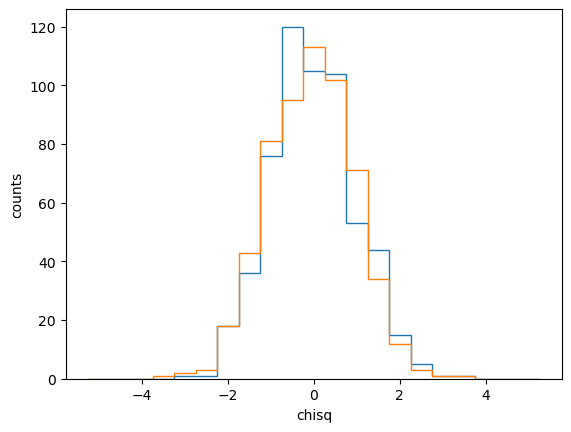

bincountsnoedm = 0.9697585878615231
mean is  -0.018659211891292365 error = 0.04026703363562272
highest count for no edm is  120
highest count for edm is  113
(0.23017241379310344, 0.9865666543001198)
(0.1896551724137931, 1.0011957773293951)


<Figure size 640x480 with 0 Axes>

In [318]:
# #loop over pseudo experiments
# npseudo = 10
# for ipseudo in range(npseudo):
#     Asymerrors, Asyms = randomiseA(Asym, 1E6)
#     diff = np.array(Asyms) - Asym
#     chisq = diff**2 / Asym
#     #randomiseA takes in input of Asym array and alters it for a different N value now

binwidth = 0.5
bins = np.arange(-5.25, 5.25+binwidth, binwidth) # 400 long 
binCentres = bins[0:-1] + (binwidth/2)
bincountsnoedm = np.array([0 for i in range(len(bins)-1)])
bincountsedm = np.array([0 for i in range(len(bins)-1)])

# print(bincountsnoedm) 
# print(bincountsedm)
# above two lines only serve purpose of showing the counts are initialised to zero
# randomiseA returns error, which is 2d for on and off AND values which is 2d for on and off
#FOR CLARITY, randomiseA returns 2 x 2D arrays

pulls1 = [] #empty pulls
pulls2 = []

NUMBEROFDATASETSGENERATED = 20 # how many iterations of the loop?... 2 for now

for x in range(NUMBEROFDATASETSGENERATED): 
    Asym_errors, Asym_vals = randomiseA(Asym, 10000)
    #returns two 2d arrays, errors and values both 2d
    pull1 = np.array( (Asym_vals[0] - Asym[0]) /(Asym_errors[0]) )
    pull2 = np.array( (Asym_vals[1] - Asym[1]) /(Asym_errors[1]) )
    
    for a in pull1:
        pulls1.append(a)
        bincountsnoedm[np.argmin(np.fabs(a-binCentres))] += 1.0
        #adds 1 count to this element of bincounts
        #print('with no edm ', p, bins[np.argmin(p-bins)])
        #print('pulls1 =', pulls1)
    for b in pull2:
        pulls2.append(b)
        bincountsedm[np.argmin(np.fabs(b-binCentres))] += 1.0
        #print('with an edm', p, bins[np.argmin(p-bins)])
        #print('pulls2 =', pulls2)
        
    
print('counts length = ', len(bincountsedm))
print('bins length =', len(bins))
#     noedmchisq = (np.array(Asym_vals[0]) - np.array(Asym[0]))**2 / (np.array(Asym_vals[0]))**2
#     edmchisq = (np.array(Asym_vals[1]) - np.array(Asym[1]))**2 / (np.array(Asym_vals[1]))**2
#     # new_data is a 2d array: contains errors and actual pseudo-values.
#     # yaxis data represents the chi squared now: two arrays. one for edm and one without


# print('pull =', pull1, 'and is of length =', len(pull1))
# print('bins =', bins, 'and is of length =', len(bins))
# plt.hist(bincountsnoedm, bins=bins)
plt.stairs(bincountsnoedm, bins)
plt.stairs(bincountsedm, bins)
plt.xlabel('chisq')
plt.ylabel('counts')
plt.show()
print('bincountsnoedm =', np.std(pulls1))
plt.savefig("Plots/histograms/chisquaredhistogram.png")
# plt.clf()
print('mean is ', np.mean(pulls1), 'error =', np.std(pulls1)/np.sqrt(len(pulls1)))

# plt.clf()
# plt.xlim(-3,3)
# plt.errorbar(bins[1:]-0.5, bincountsnoedm, linestyle='', marker='o') # this isneeded to cross check the shift
#has it been moved by guassian? is 'pull' a gaussian centred on zero

#plt.hist(bins[:-1], bins, weights=bincountsedm, edgecolor='black')
#plt.title('chi squared distribution over randomised data')
#plt.xlabel('bins')
#plt.ylabel('chi squared')
#plt.grid(True)
#plt.show()

# sum all up over 
#print('pull1 is = ', pull1, 'len =', len(pull1))
#print('pull2 is =', pull2, 'len =', len(pull2))
print('highest count for no edm is ', np.max(bincountsnoedm))
print('highest count for edm is ', np.max(bincountsedm))
def GetMeanStd(x, fx):
    mean = np.sum(x*fx) / np.sum(fx)
    var = np.sum(x**2*fx) / np.sum(fx) - mean**2
    return mean, np.sqrt(var)



print(GetMeanStd(bins[:-1] + (bins[1]-bins[0]), bincountsnoedm))
print(GetMeanStd(bins[:-1] + (bins[1]-bins[0]), bincountsedm))



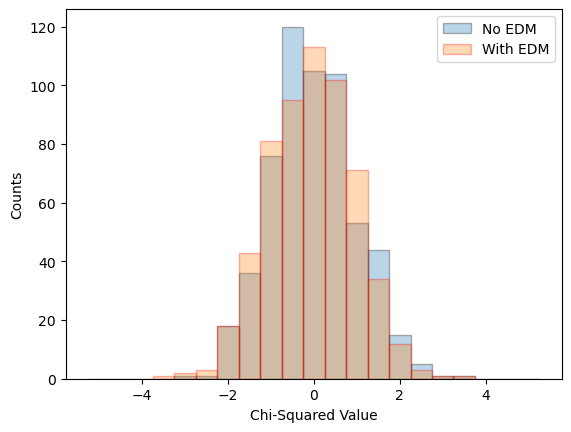

bins = [-5.25 -4.75 -4.25 -3.75 -3.25 -2.75 -2.25 -1.75 -1.25 -0.75 -0.25  0.25
  0.75  1.25  1.75  2.25  2.75  3.25  3.75  4.25  4.75  5.25]
bin centres = [-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5
  2.   2.5  3.   3.5  4.   4.5  5. ]
mean and standard deviation for no EDM are  (-0.019827586206896553, 0.9865666543001198)
mean and standard deviation for EDM are  (-0.0603448275862069, 1.0011957773293951)


In [319]:
bins = np.arange(-5.5 + binwidth/2, 5.5 + binwidth/2, binwidth)
bin_centres = (bins[:-1] + bins[1:]) / 2
bin_indices = np.digitize(pulls1, bins) - 1  # Get indices of bins
for idx in bin_indices:
    if 0 <= idx < len(bincountsnoedm):
        bincountsnoedm[idx] += 1.0
        
plt.hist(pulls1, bins=bins, edgecolor='black', alpha=0.3, label="No EDM")
plt.hist(pulls2, bins=bins, edgecolor='red', alpha=0.3, label="With EDM")
plt.xlabel('Chi-Squared Value')
plt.ylabel('Counts')
plt.legend()
plt.show()

print('bins =', bins)
print('bin centres =', bin_centres) 

print('mean and standard deviation for no EDM are ', GetMeanStd(bin_centres, bincountsnoedm))
print('mean and standard deviation for EDM are ', GetMeanStd(bin_centres, bincountsedm))

(2, 29)
[0.0139765  0.01397484 0.01396987 0.0139616  0.01395006 0.01393535
 0.01391767 0.01389736 0.01387501 0.01385149 0.01382801 0.01380609
 0.01378746 0.01377384 0.01376663 0.01376663 0.01377384 0.01378746
 0.01380609 0.01382801 0.01385149 0.01387501 0.01389736 0.01391767
 0.01393535 0.01395006 0.0139616  0.01396987 0.01397484]
[0.0139765  0.01397333 0.01396395 0.01394883 0.01392873 0.0139048
 0.01387852 0.01385172 0.01382642 0.01380452 0.0137875  0.01377597
 0.01376947 0.01376663 0.01376578 0.01376578 0.01376663 0.01376947
 0.01377597 0.0137875  0.01380452 0.01382642 0.01385172 0.01387852
 0.0139048  0.01392873 0.01394883 0.01396395 0.01397333]


Text(0.5, 0, 'Alpha')

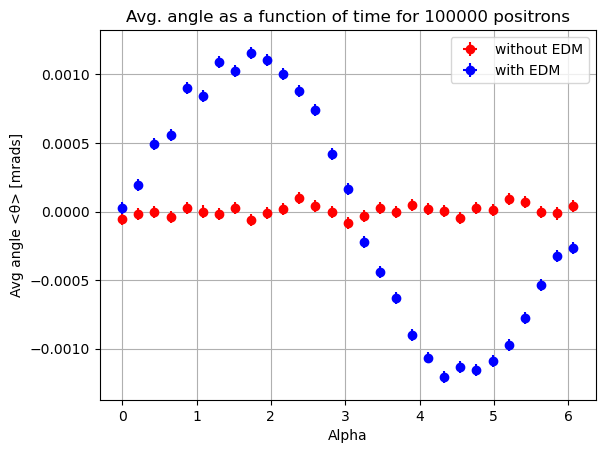

In [320]:
# finding PER A NUMBER OF COUNTS how the chisq distribution loosks for asym and for avg angle...
# right now randomiseA creates random values for the asymmetry
# need an equivalent for the avg angle
#initialise

randomThetaerr1, randomThetaerr2 = np.zeros(29), np.zeros(29)
randomTheta1, randomTheta2 = np.zeros(29), np.zeros(29)
randomThetaerr = [randomThetaerr1, randomThetaerr2]
randomTheta = [randomTheta1, randomTheta2]
# #stdev = 0.01
# mean0 = np.mean(avgangles[0])
# stdev0 = np.sqrt((np.sum((avgangles[0] - np.mean(avgangles[0]))**2)/29))

# mean1 = np.mean(avgangles[1])
# stdev1 = np.sqrt((np.sum((avgangles[1] - np.mean(avgangles[1]))**2)/29))

# stdev = [stdev0, stdev1]


def randomiseAvg(avgangle, selectNvalue):
    # creating function to randomise Asym values
    randomThetaerr1, randomThetaerr2 = np.zeros(29), np.zeros(29)
    randomTheta1, randomTheta2 = np.zeros(29), np.zeros(29)
    randomThetaerr = [randomThetaerr1, randomThetaerr2]
    randomTheta = [randomTheta1, randomTheta2]
    tmpThetaerr1, tmpThetaerr2 = np.zeros(29), np.zeros(29)
    tmpThetaerr = [tmpThetaerr1, tmpThetaerr2]
    
    
    for j in range(len(avgangle)):
        for n in range(len(avgangle[j])):
#           tmpThetaerr[j][n] = stdev[j] / np.sqrt(selectNvalue)
#           randomTheta[j][n] = np.random.normal(avgangle[j][n], tmpThetaerr[j][n])
#           randomThetaerr[j][n] = stdev[j] / np.sqrt(selectNvalue)
            #tmpThetaerr[j][n] = np.sqrt( (np.sum((avgangles - np.mean(avgangles))**2) /29) / np.sqrt(selectNvalue) )
            tmpThetaerr[j][n] = standdev[j][n] / np.sqrt(selectNvalue)
            randomTheta[j][n] = np.random.normal(avgangle[j][n], tmpThetaerr[j][n])
            randomThetaerr[j][n] = tmpThetaerr[j][n]
            #np.sqrt( (np.sum((randomTheta - np.mean(randomTheta))**2)/29) / np.sqrt(selectNvalue) )
    return randomThetaerr, randomTheta


#### CHANGE THIS ####
numberofpositrons = 100000
print(np.shape(standdev))
print(standdev[0][:])
print(standdev[1][:])
thetaerrs, thetas = np.array(randomiseAvg(avgangles, numberofpositrons))

#print(thetaerrs)
plt.errorbar(phaseval, thetas[0], xerr=0, yerr=thetaerrs[0], color='r', label='without EDM', linestyle='', marker='o')
plt.errorbar(phaseval, thetas[1], xerr=0, yerr=thetaerrs[1], color='b', label='with EDM', linestyle='', marker='o')
plt.title(f'Avg. angle as a function of time for {numberofpositrons} positrons')
plt.grid()
plt.legend()
plt.ylabel('Avg angle <θ> [mrads]')
plt.xlabel('Alpha')

In [321]:
#optimal number of decays for the non-EDM case to truly resemble a straight line?

g2s/user/jprice/www/Project2024-25/InputFiles/G2_29_withEDM.pkl


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_7936\1061457622.py:12: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar( ScalarMappable(norm=qcs.norm, cmap=qcs.cmap) )#, ticks=range(vmin, vmax+5, 5))   )


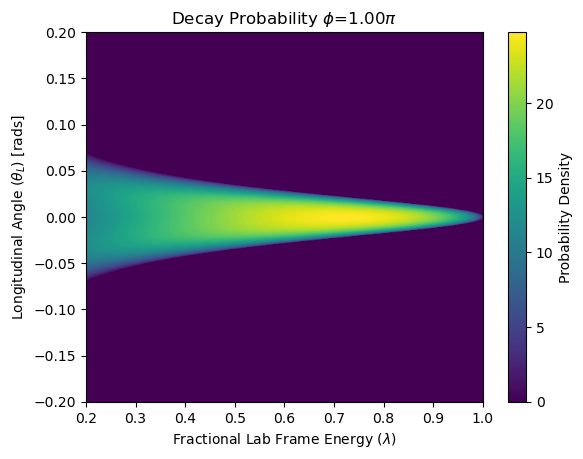

In [324]:
phaseIndex = 29
#surely we need 'withEDM'
fname = f'g2s/user/jprice/www/Project2024-25/InputFiles/G2_{phaseIndex:02d}_withEDM.pkl'
print(fname)
f= open(file_path, "rb")
X,Y,Z = pickle.load(f)
plt.xlabel(f'Fractional Lab Frame Energy ({lamStem})')
plt.ylabel(r'Longitudinal Angle ($\theta_L$) [rads]')
plt.title(f'Decay Probability {phiStem}={phaseIndex/29:.2f}{piStem}')

qcs = plt.contourf(X,Y,Z, levels, cmap = newcmp)
cbar = plt.colorbar( ScalarMappable(norm=qcs.norm, cmap=qcs.cmap) )#, ticks=range(vmin, vmax+5, 5))   )
cbar.ax.set_ylabel(r'Probability Density')
outname = outFolder + f"ProbabilityDensity.png"
plt.savefig(outname)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_7936\1534716531.py:35: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(ScalarMappable(norm=qcs.norm, cmap=qcs.cmap))


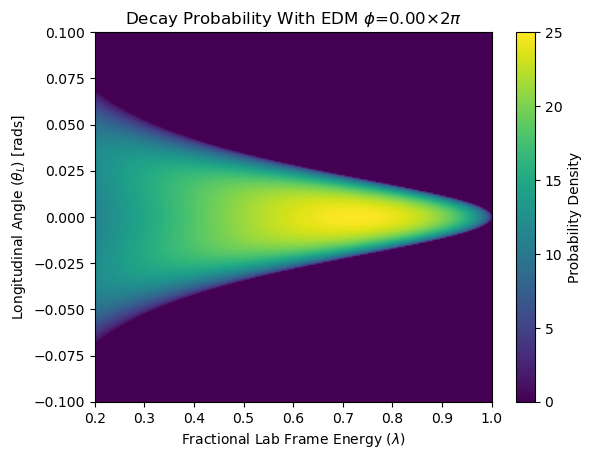

Saved: 3dplots/ProbabilityDensitywithEDM_00.png


<Figure size 640x480 with 0 Axes>

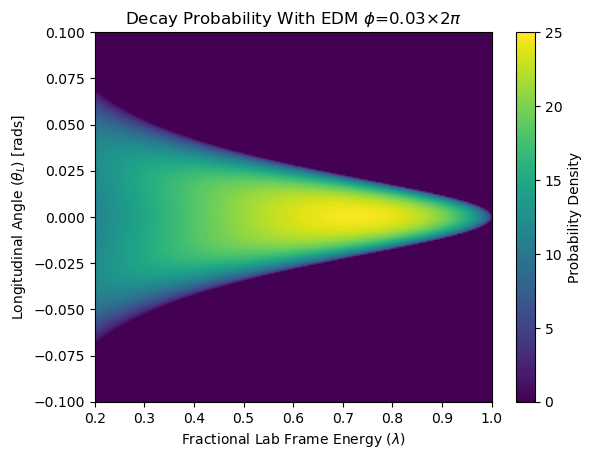

Saved: 3dplots/ProbabilityDensitywithEDM_01.png


<Figure size 640x480 with 0 Axes>

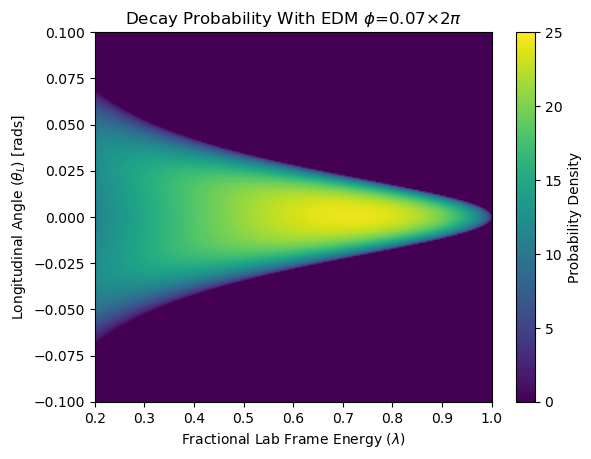

Saved: 3dplots/ProbabilityDensitywithEDM_02.png


<Figure size 640x480 with 0 Axes>

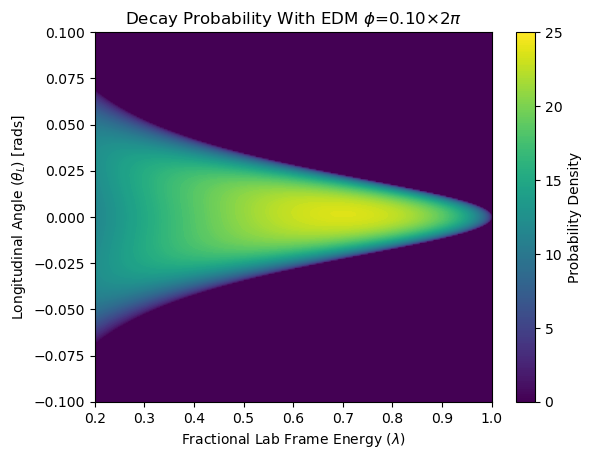

Saved: 3dplots/ProbabilityDensitywithEDM_03.png


<Figure size 640x480 with 0 Axes>

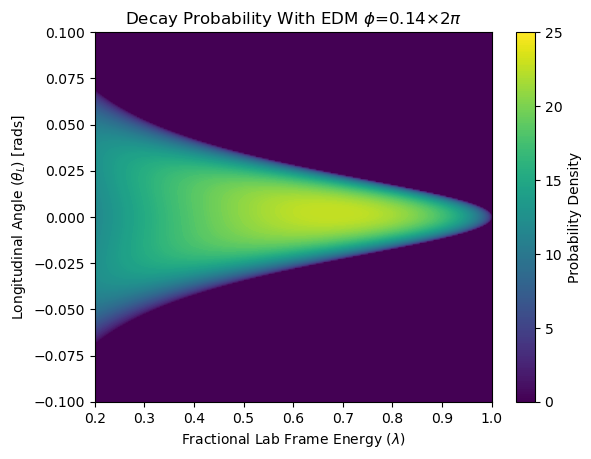

Saved: 3dplots/ProbabilityDensitywithEDM_04.png


<Figure size 640x480 with 0 Axes>

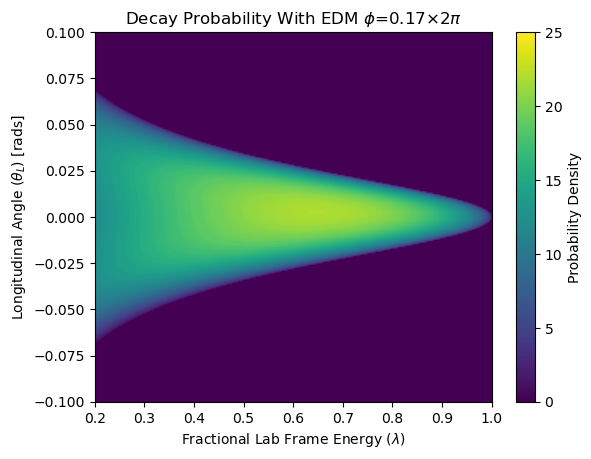

Saved: 3dplots/ProbabilityDensitywithEDM_05.png


<Figure size 640x480 with 0 Axes>

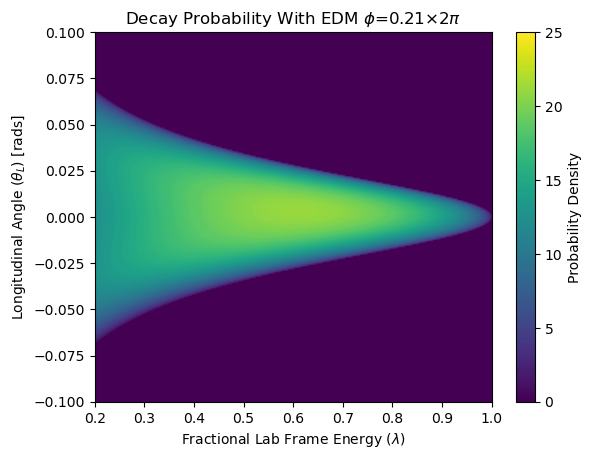

Saved: 3dplots/ProbabilityDensitywithEDM_06.png


<Figure size 640x480 with 0 Axes>

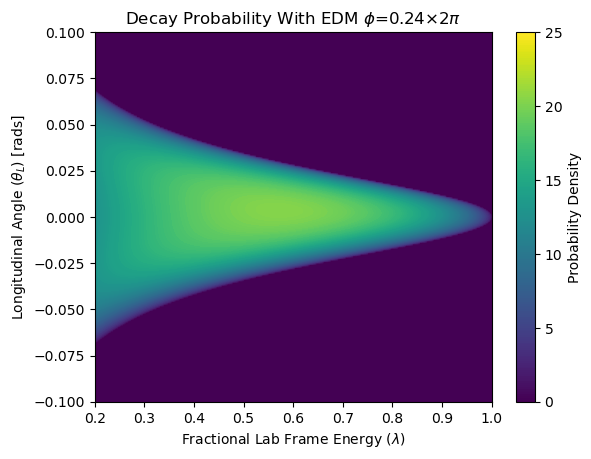

Saved: 3dplots/ProbabilityDensitywithEDM_07.png


<Figure size 640x480 with 0 Axes>

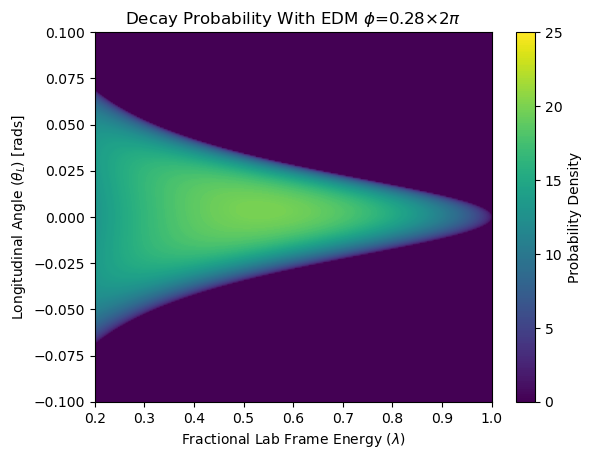

Saved: 3dplots/ProbabilityDensitywithEDM_08.png


<Figure size 640x480 with 0 Axes>

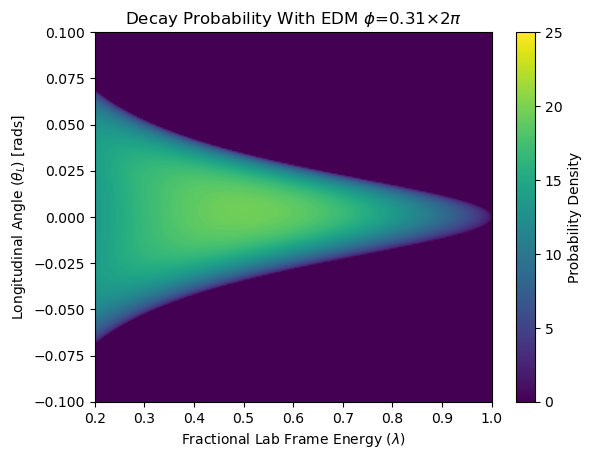

Saved: 3dplots/ProbabilityDensitywithEDM_09.png


<Figure size 640x480 with 0 Axes>

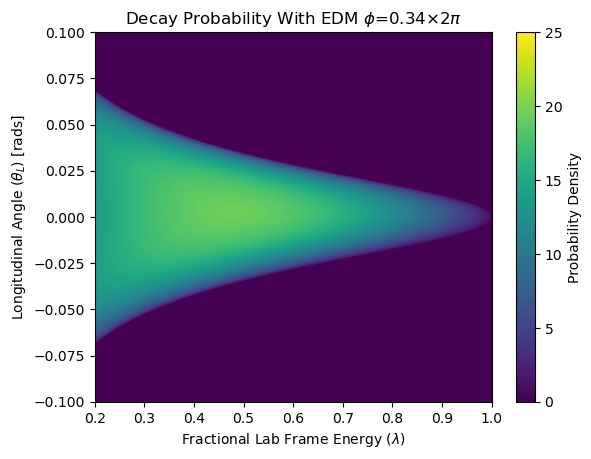

Saved: 3dplots/ProbabilityDensitywithEDM_10.png


<Figure size 640x480 with 0 Axes>

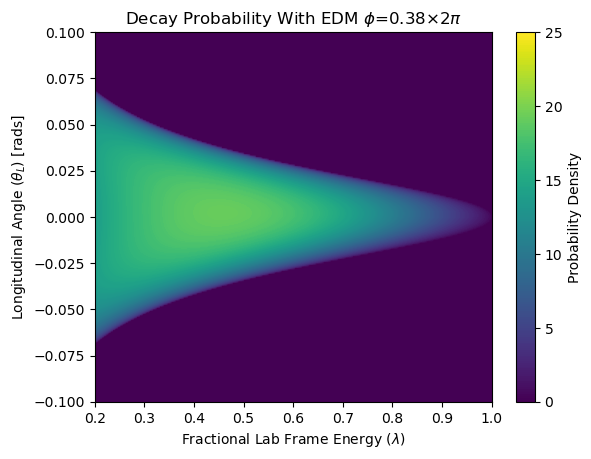

Saved: 3dplots/ProbabilityDensitywithEDM_11.png


<Figure size 640x480 with 0 Axes>

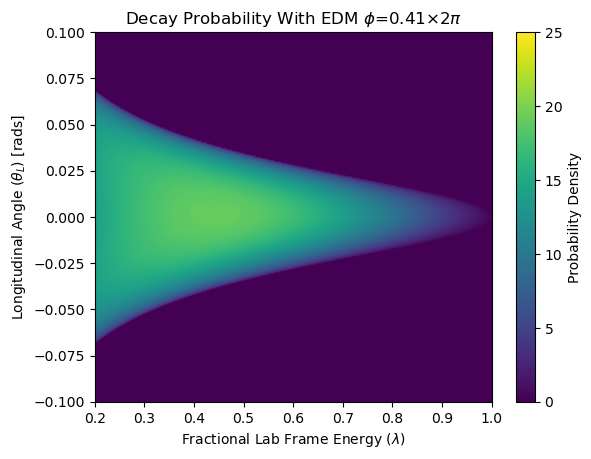

Saved: 3dplots/ProbabilityDensitywithEDM_12.png


<Figure size 640x480 with 0 Axes>

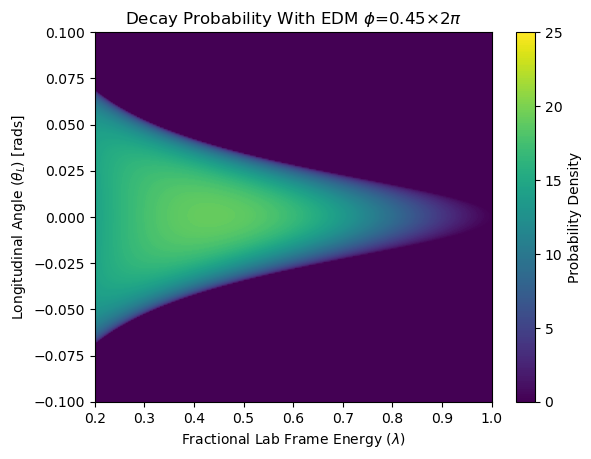

Saved: 3dplots/ProbabilityDensitywithEDM_13.png


<Figure size 640x480 with 0 Axes>

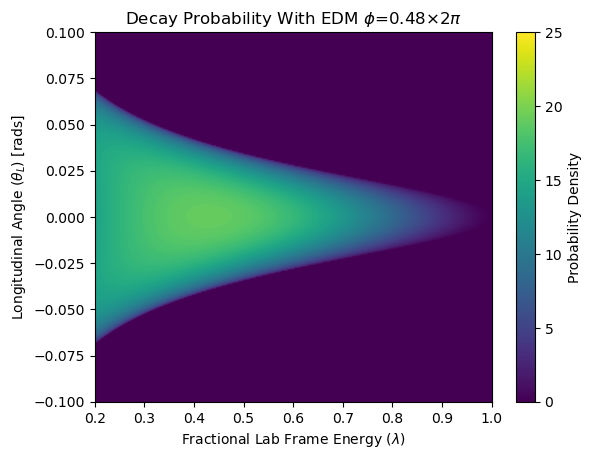

Saved: 3dplots/ProbabilityDensitywithEDM_14.png


<Figure size 640x480 with 0 Axes>

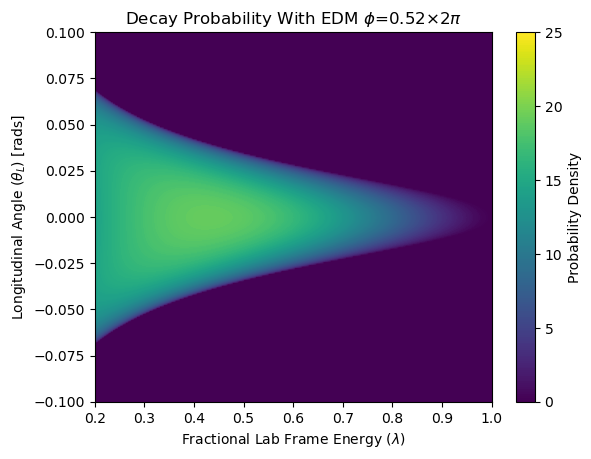

Saved: 3dplots/ProbabilityDensitywithEDM_15.png


<Figure size 640x480 with 0 Axes>

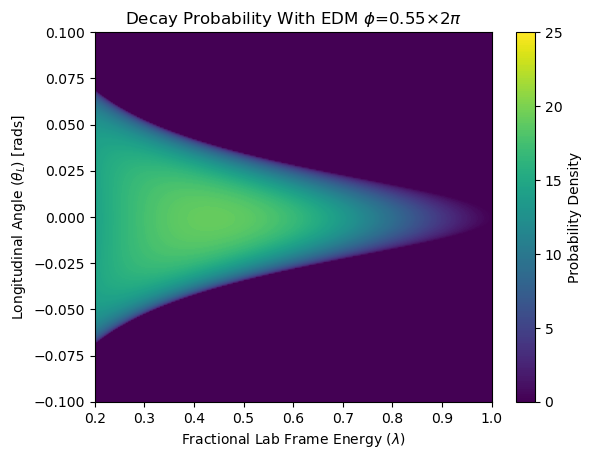

Saved: 3dplots/ProbabilityDensitywithEDM_16.png


<Figure size 640x480 with 0 Axes>

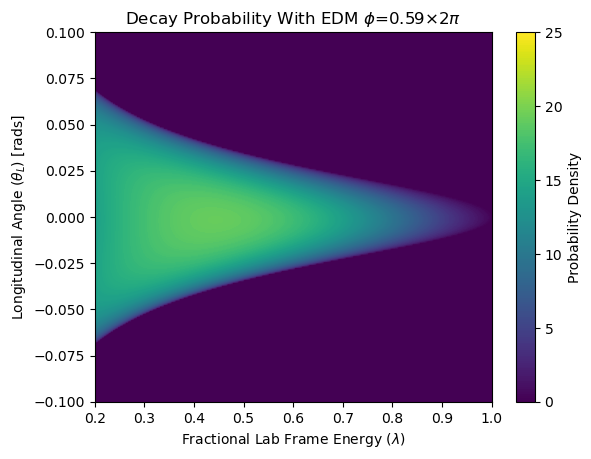

Saved: 3dplots/ProbabilityDensitywithEDM_17.png


<Figure size 640x480 with 0 Axes>

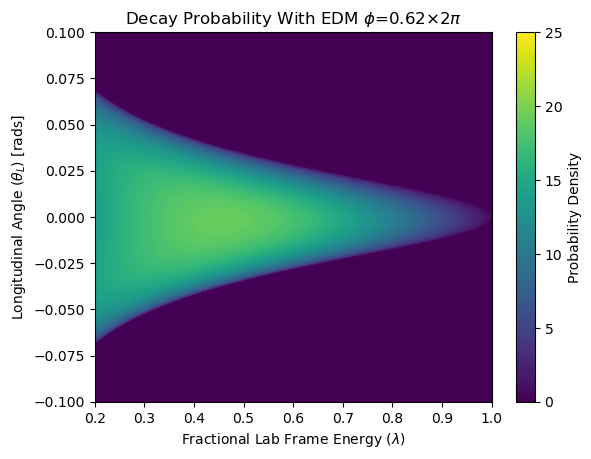

Saved: 3dplots/ProbabilityDensitywithEDM_18.png


<Figure size 640x480 with 0 Axes>

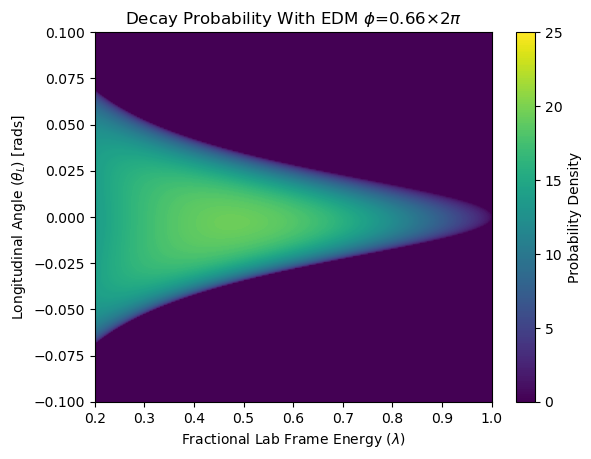

Saved: 3dplots/ProbabilityDensitywithEDM_19.png


<Figure size 640x480 with 0 Axes>

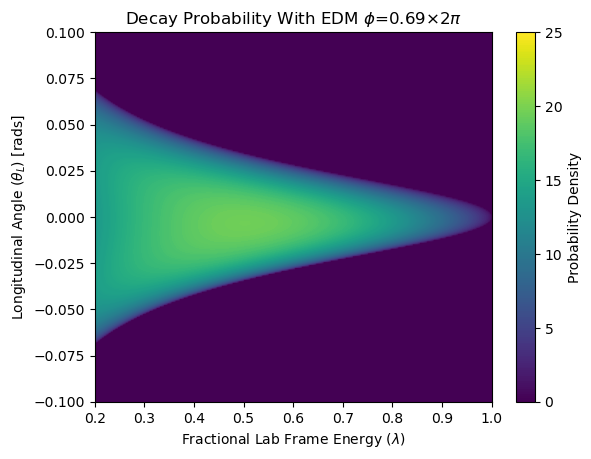

Saved: 3dplots/ProbabilityDensitywithEDM_20.png


<Figure size 640x480 with 0 Axes>

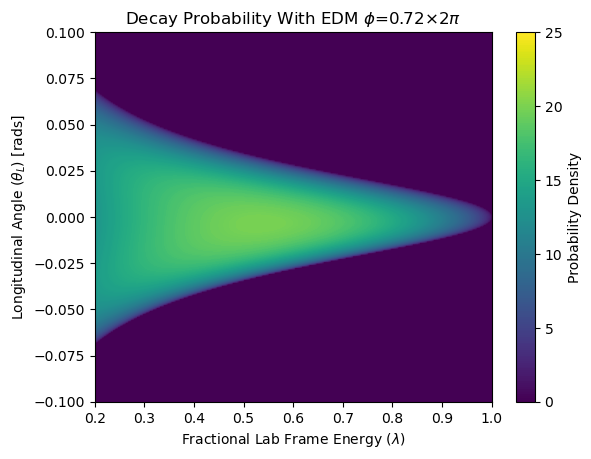

Saved: 3dplots/ProbabilityDensitywithEDM_21.png


<Figure size 640x480 with 0 Axes>

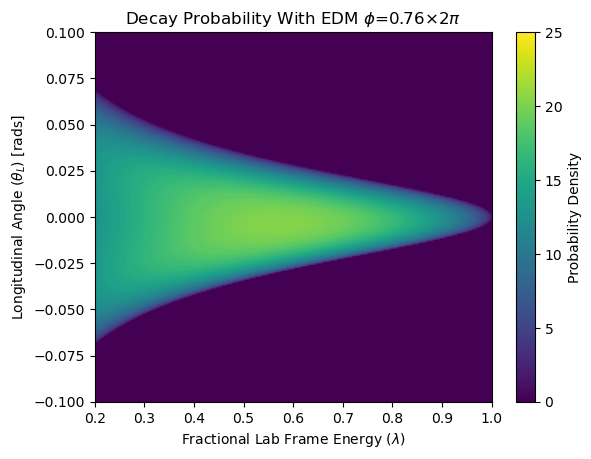

Saved: 3dplots/ProbabilityDensitywithEDM_22.png


<Figure size 640x480 with 0 Axes>

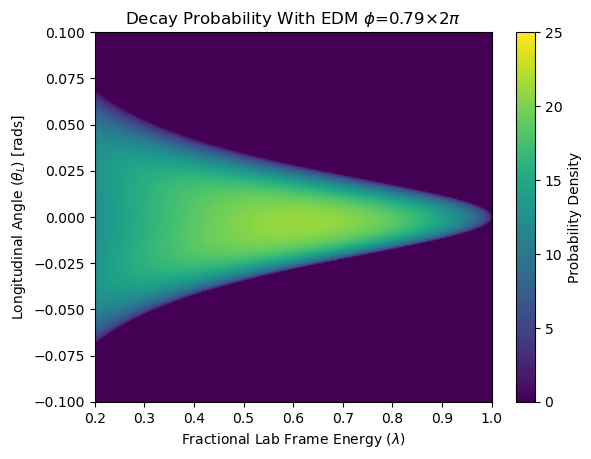

Saved: 3dplots/ProbabilityDensitywithEDM_23.png


<Figure size 640x480 with 0 Axes>

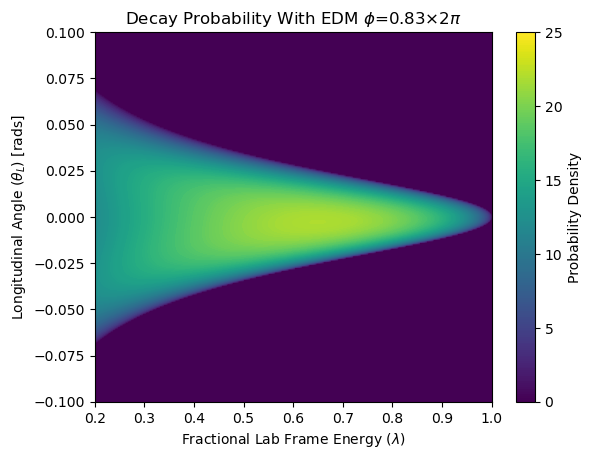

Saved: 3dplots/ProbabilityDensitywithEDM_24.png


<Figure size 640x480 with 0 Axes>

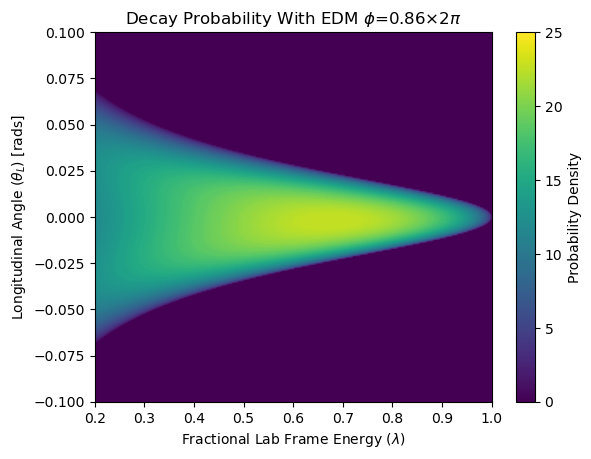

Saved: 3dplots/ProbabilityDensitywithEDM_25.png


<Figure size 640x480 with 0 Axes>

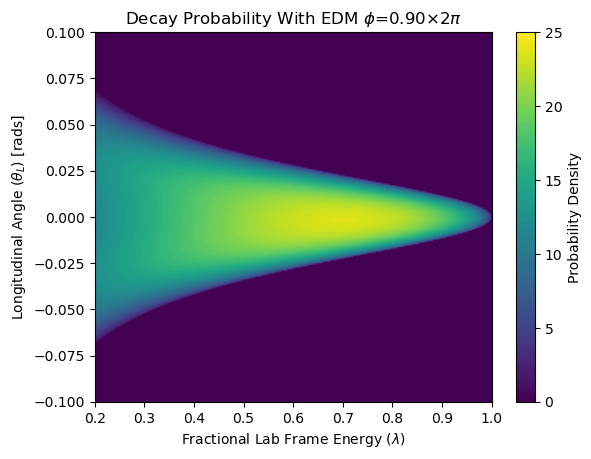

Saved: 3dplots/ProbabilityDensitywithEDM_26.png


<Figure size 640x480 with 0 Axes>

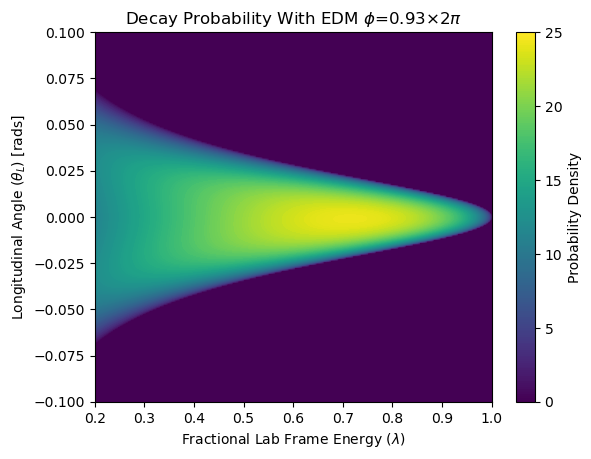

Saved: 3dplots/ProbabilityDensitywithEDM_27.png


<Figure size 640x480 with 0 Axes>

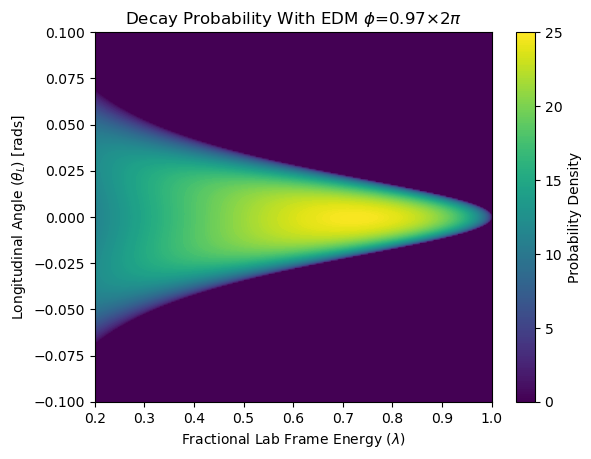

Saved: 3dplots/ProbabilityDensitywithEDM_28.png


<Figure size 640x480 with 0 Axes>

In [325]:
# trying to loop this code. FOR THE EDM CASE...
levels=200
#levels = np.linspace(0, 1, 100)  
newcmp = "viridis"  
outFolder = "3dplots/"
os.makedirs(outFolder, exist_ok=True)

for phaseIndex in range(29): 
    #if not (phaseIndex == 0 or phaseIndex == 7):
    #    continue
    fname = f'g2s/user/jprice/www/Project2024-25/InputFiles/G2_{phaseIndex:02d}_withEDM.pkl'
    
    try:
        with open(fname, "rb") as f:
            X, Y, Z = pickle.load(f)
    except FileNotFoundError:
        print(f"File not found: {fname}")
        continue
    
    plt.figure()
    plt.xlabel(r'Fractional Lab Frame Energy ($\lambda$)')
    plt.ylabel(r'Longitudinal Angle ($\theta_L$) [rads]')
    plt.title(rf'Decay Probability With EDM $\phi$={phaseIndex/29:.2f}$\times 2 \pi$')
    
    #if (phaseIndex == 0):
    #    qcs = plt.contourf(X, Y, Z, levels, cmap=qcs.cmap)
    #    maxnorm = qcs.norm
    #    maxcmap = qcs.cmap
    
    #qcs = plt.contourf(X, Y, Z, levels, cmap=qcs.cmap)
    qcs = plt.contourf(X, Y, Z, levels, cmap=qcs.cmap, vmin=0.0, vmax=25)
    #print(phaseIndex, maxcmap)
    #qcs = plt.contourf(X, Y, Z, levels, cmap=maxcmap)

    cbar = plt.colorbar(ScalarMappable(norm=qcs.norm, cmap=qcs.cmap))
    #cbar = plt.colorbar(ScalarMappable(norm=maxnorm, cmap=maxcmap))
    cbar.ax.set_ylabel(r'Probability Density')
    
    plt.ylim([-0.1, 0.1])
    outname = os.path.join(outFolder, f"ProbabilityDensitywithEDM_{phaseIndex:02d}.png")
    
    plt.show()
    # plt.savefig(outname) censored this
    plt.savefig(outname, bbox_inches=None, pad_inches=0.1)
    plt.clf()
    print(f"Saved: {outname}")

In [326]:
from PIL import Image
import glob

# Path to images (modify if needed)
image_files = sorted(glob.glob("3dplots/ProbabilityDensitywithEDM_*.png"))  # Finds all matching files

# Open images
images = [Image.open(img) for img in image_files]

# Create and save the GIF
images[0].save("ProbabilityDensitywithEDM.gif", save_all=True, append_images=images[1:], duration=100, loop=0, optimize=False)

print("GIF saved as ProbabilityDensitywithEDM.gif")


GIF saved as ProbabilityDensitywithEDM.gif


In [327]:
# trying to loop this code. FOR THE NON EDM CASE...
levels=200
#levels = np.linspace(0, 1, 100)  
newcmp = "viridis"  
outFolder = "3dplots/"
os.makedirs(outFolder, exist_ok=True)

for phaseIndex in range(29): 
    #if not (phaseIndex == 0 or phaseIndex == 7):
    #    continue
    fname = f'g2s/user/jprice/www/Project2024-25/InputFiles/G2_{phaseIndex:02d}.pkl'
    
    try:
        with open(fname, "rb") as f:
            X, Y, Z = pickle.load(f)
    except FileNotFoundError:
        print(f"File not found: {fname}")
        continue
    
    plt.figure()
    plt.xlabel(r'Fractional Lab Frame Energy ($\lambda$)')
    plt.ylabel(r'Longitudinal Angle ($\theta_L$) [rads]')
    plt.title(rf'Decay Probability no EDM $\phi$={phaseIndex/29:.2f}$\pi$')
    
    #if (phaseIndex == 0):
    #    qcs = plt.contourf(X, Y, Z, levels, cmap=qcs.cmap)
    #    maxnorm = qcs.norm
    #    maxcmap = qcs.cmap
    
    #qcs = plt.contourf(X, Y, Z, levels, cmap=qcs.cmap)
    qcs = plt.contourf(X, Y, Z, levels, cmap=qcs.cmap, vmin=0.0, vmax=25)
    #print(phaseIndex, maxcmap)
    #qcs = plt.contourf(X, Y, Z, levels, cmap=maxcmap)

    cbar = plt.colorbar(ScalarMappable(norm=qcs.norm, cmap=qcs.cmap))
    #cbar = plt.colorbar(ScalarMappable(norm=maxnorm, cmap=maxcmap))
    cbar.ax.set_ylabel(r'Probability Density')
    
    plt.ylim([-0.1, 0.1])
    outname = os.path.join(outFolder, f"ProbabilityDensitynoEDM_{phaseIndex:02d}.png")
    
    #plt.show()
    #plt.savefig(outname) censored this myself
    plt.savefig(outname, bbox_inches=None, pad_inches=0.1)
    plt.clf()
    print(f"Saved: {outname}")

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_7936\206239404.py:35: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(ScalarMappable(norm=qcs.norm, cmap=qcs.cmap))


Saved: 3dplots/ProbabilityDensitynoEDM_00.png
Saved: 3dplots/ProbabilityDensitynoEDM_01.png
Saved: 3dplots/ProbabilityDensitynoEDM_02.png
Saved: 3dplots/ProbabilityDensitynoEDM_03.png
Saved: 3dplots/ProbabilityDensitynoEDM_04.png
Saved: 3dplots/ProbabilityDensitynoEDM_05.png
Saved: 3dplots/ProbabilityDensitynoEDM_06.png
Saved: 3dplots/ProbabilityDensitynoEDM_07.png
Saved: 3dplots/ProbabilityDensitynoEDM_08.png
Saved: 3dplots/ProbabilityDensitynoEDM_09.png
Saved: 3dplots/ProbabilityDensitynoEDM_10.png
Saved: 3dplots/ProbabilityDensitynoEDM_11.png
Saved: 3dplots/ProbabilityDensitynoEDM_12.png
Saved: 3dplots/ProbabilityDensitynoEDM_13.png
Saved: 3dplots/ProbabilityDensitynoEDM_14.png
Saved: 3dplots/ProbabilityDensitynoEDM_15.png
Saved: 3dplots/ProbabilityDensitynoEDM_16.png
Saved: 3dplots/ProbabilityDensitynoEDM_17.png
Saved: 3dplots/ProbabilityDensitynoEDM_18.png
Saved: 3dplots/ProbabilityDensitynoEDM_19.png


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_7936\206239404.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Saved: 3dplots/ProbabilityDensitynoEDM_20.png
Saved: 3dplots/ProbabilityDensitynoEDM_21.png
Saved: 3dplots/ProbabilityDensitynoEDM_22.png
Saved: 3dplots/ProbabilityDensitynoEDM_23.png
Saved: 3dplots/ProbabilityDensitynoEDM_24.png
Saved: 3dplots/ProbabilityDensitynoEDM_25.png
Saved: 3dplots/ProbabilityDensitynoEDM_26.png
Saved: 3dplots/ProbabilityDensitynoEDM_27.png
Saved: 3dplots/ProbabilityDensitynoEDM_28.png


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [243]:
from PIL import Image
import glob

# Path to images (modify if needed)
image_files = sorted(glob.glob("3dplots/ProbabilityDensitynoEDM_*.png"))  # Finds all matching files

# Open images
images = [Image.open(img) for img in image_files]

# Create and save the GIF
images[0].save("ProbabilityDensitynoEDM.gif", save_all=True, append_images=images[1:], duration=100, loop=0, optimize=False)

print("GIF saved as ProbabilityDensitynoEDM.gif")


GIF saved as ProbabilityDensitynoEDM.gif


In [245]:
array1 = z
array2 = theta
array3 = l

if not os.path.exists('changinglambdaplots'):
    os.makedirs('changinglambdaplots')

lambda_values = np.arange(0, 1.1, 0.1)  #start from 0.6, increase by 0.1 until 1.0

for lambda_val in lambda_values:
    #mask = np.isclose(array3, lambda_val, atol=0.05)
    xdata = array2
    ydata = array1
    
    if len(xdata) > 0 and len(ydata) > 0:
        # Create a plot
        plt.figure(figsize=(8, 6))
        plt.plot(xdata, ydata, 'o', markersize=3, label=f'Lambda = {lambda_val:.1f}')
        plt.xlabel('theta')
        plt.ylabel('probability density')
        plt.title(r'Plot of $z$ vs $/theta$ for $\lambda$ = {lambda_val:.1f}')
        plt.legend()
        plot_filename = f'changinglambdaplots/lambda_{lambda_val:.1f}.png'
        plt.savefig(plot_filename)
        plt.close()

        print(f"Plot for lambda = {lambda_val:.1f} saved to {plot_filename}")
    else:
        print(f"No data found for lambda = {lambda_val:.1f}, skipping.")

print("Plotting complete.")


Plot for lambda = 0.0 saved to changinglambdaplots/lambda_0.0.png
Plot for lambda = 0.1 saved to changinglambdaplots/lambda_0.1.png
Plot for lambda = 0.2 saved to changinglambdaplots/lambda_0.2.png
Plot for lambda = 0.3 saved to changinglambdaplots/lambda_0.3.png
Plot for lambda = 0.4 saved to changinglambdaplots/lambda_0.4.png
Plot for lambda = 0.5 saved to changinglambdaplots/lambda_0.5.png
Plot for lambda = 0.6 saved to changinglambdaplots/lambda_0.6.png
Plot for lambda = 0.7 saved to changinglambdaplots/lambda_0.7.png
Plot for lambda = 0.8 saved to changinglambdaplots/lambda_0.8.png
Plot for lambda = 0.9 saved to changinglambdaplots/lambda_0.9.png
Plot for lambda = 1.0 saved to changinglambdaplots/lambda_1.0.png
Plotting complete.


In [246]:
# run some pseudo experiments 

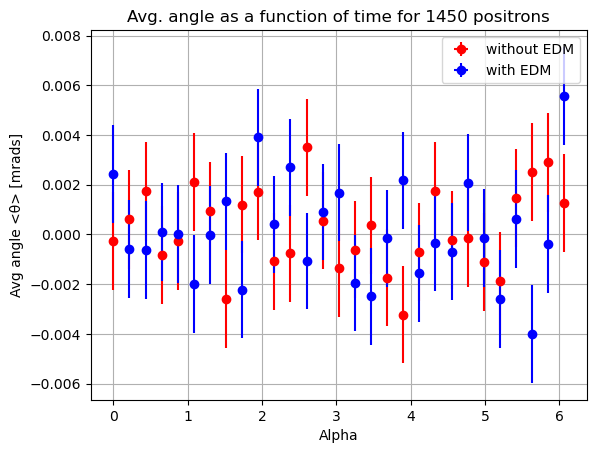

<Figure size 640x480 with 0 Axes>

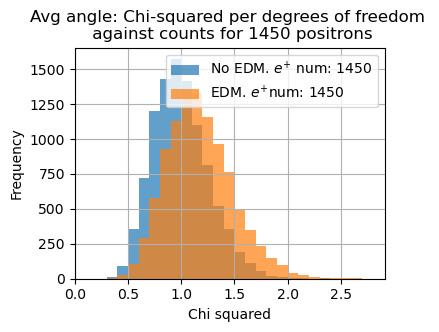

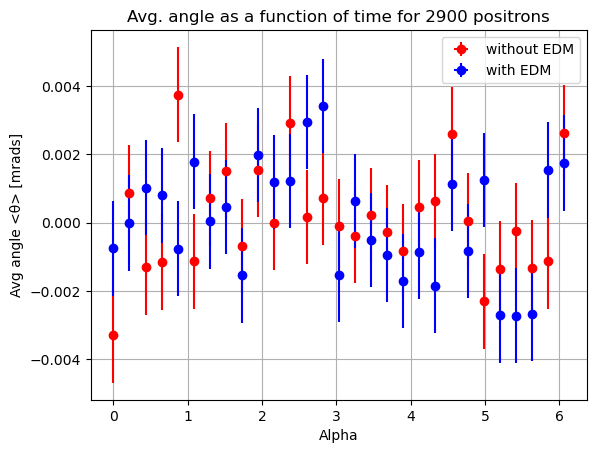

<Figure size 640x480 with 0 Axes>

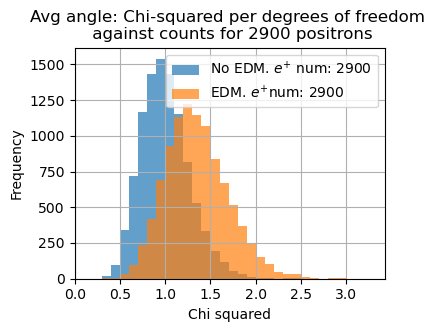

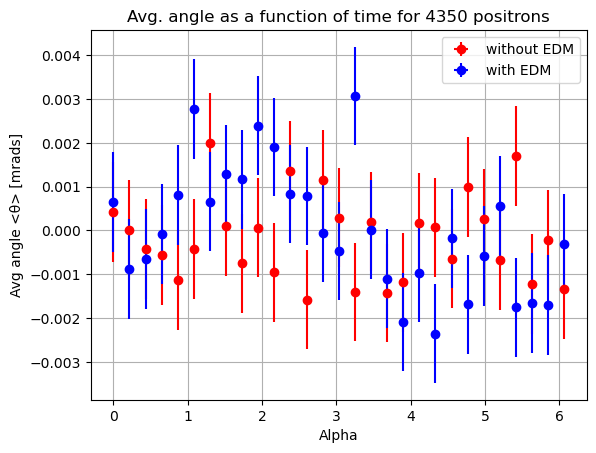

<Figure size 640x480 with 0 Axes>

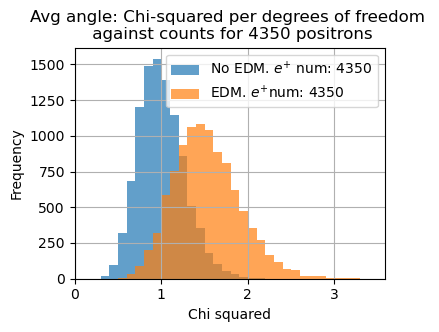

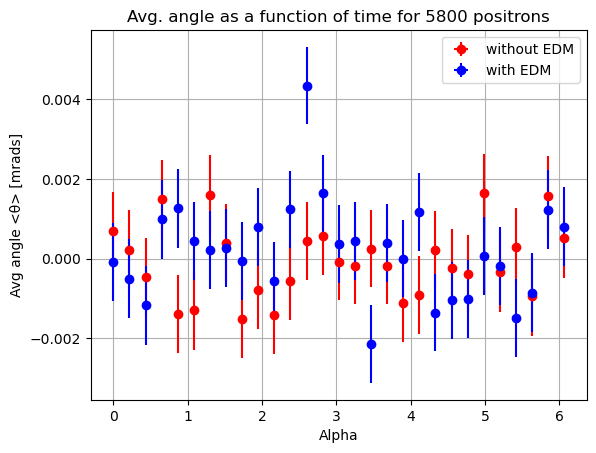

<Figure size 640x480 with 0 Axes>

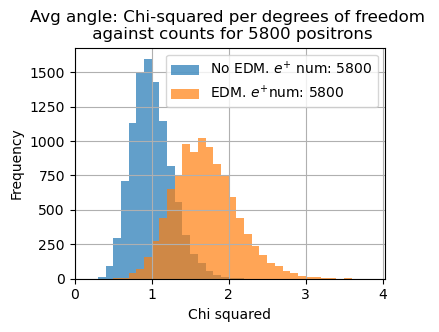

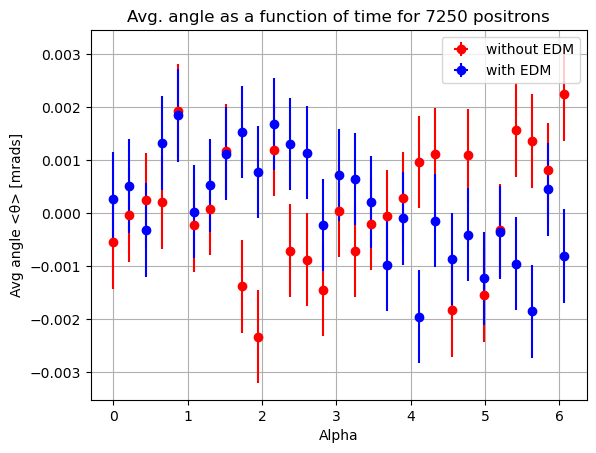

<Figure size 640x480 with 0 Axes>

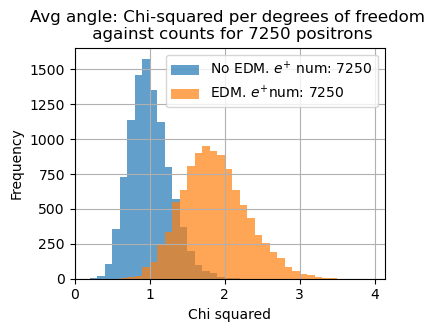

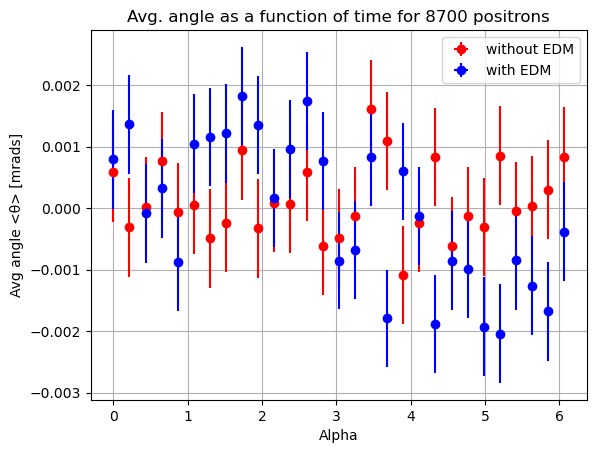

<Figure size 640x480 with 0 Axes>

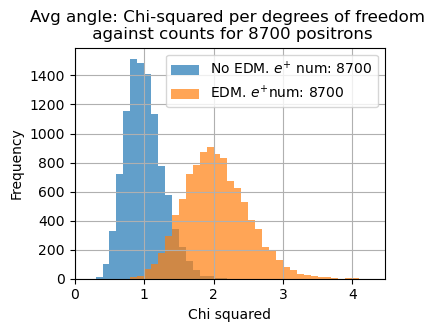

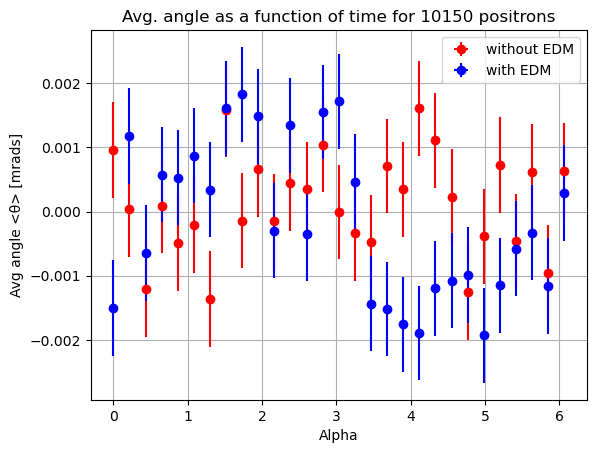

<Figure size 640x480 with 0 Axes>

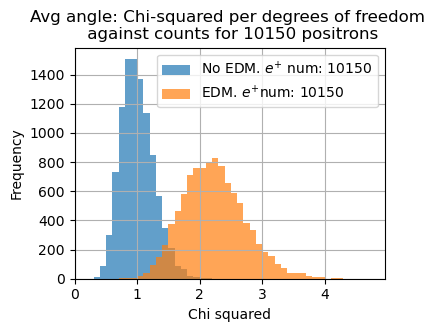

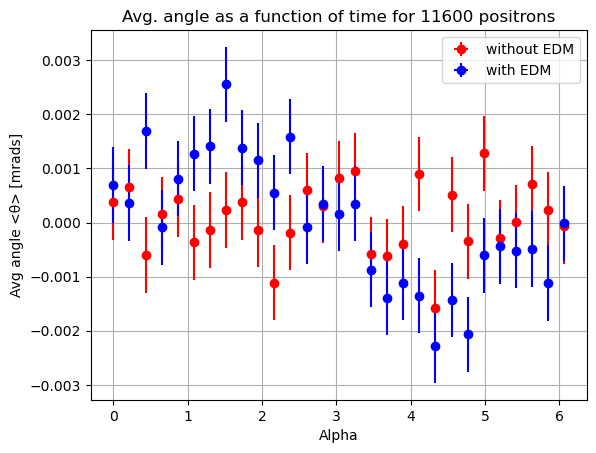

<Figure size 640x480 with 0 Axes>

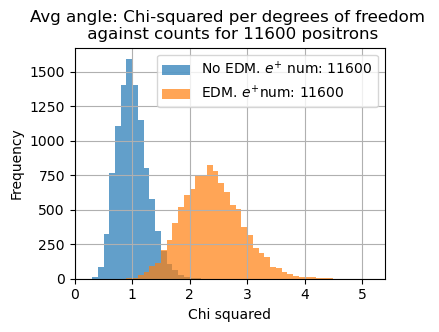

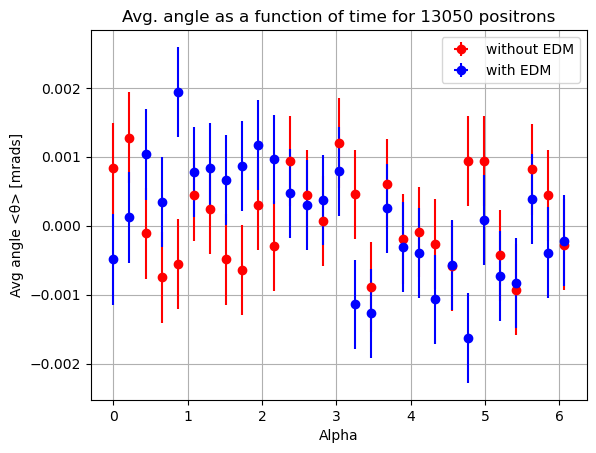

<Figure size 640x480 with 0 Axes>

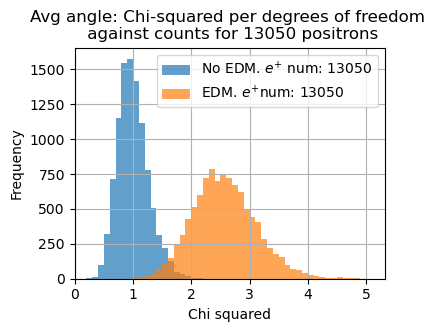

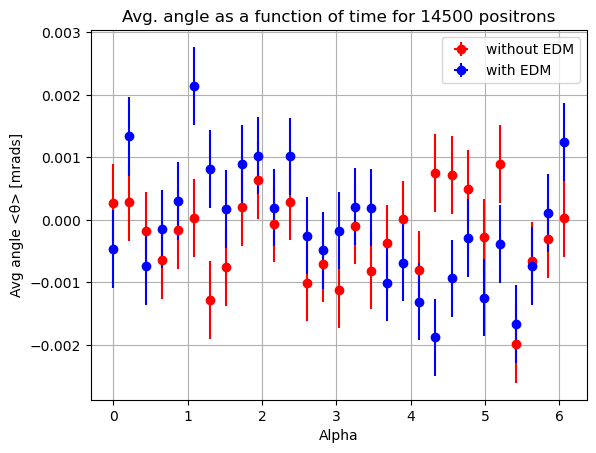

<Figure size 640x480 with 0 Axes>

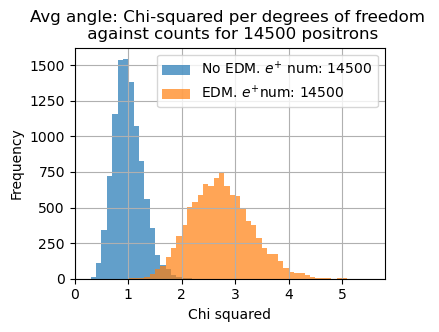

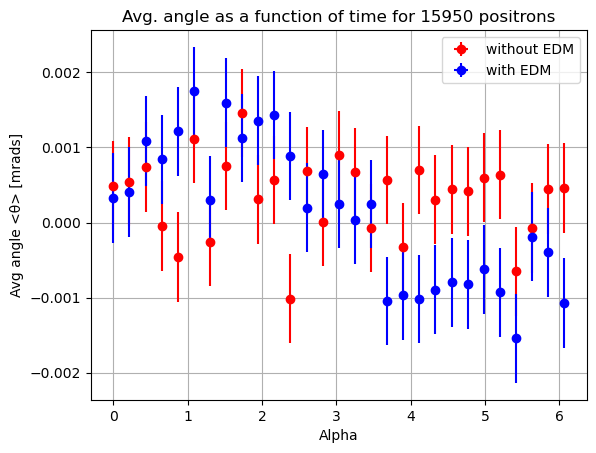

<Figure size 640x480 with 0 Axes>

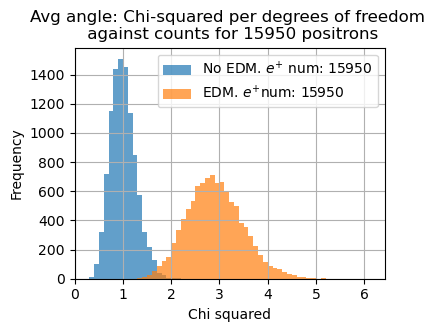

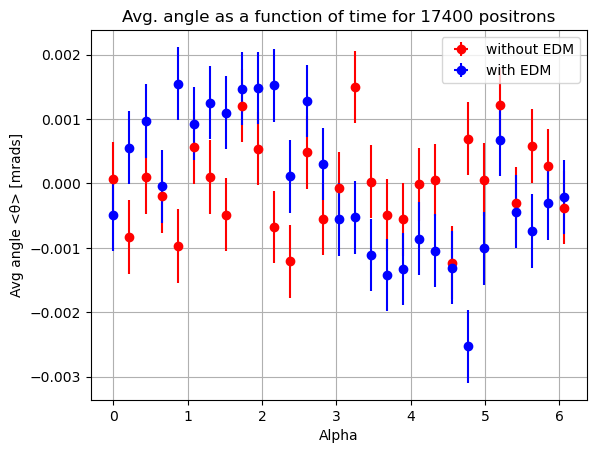

<Figure size 640x480 with 0 Axes>

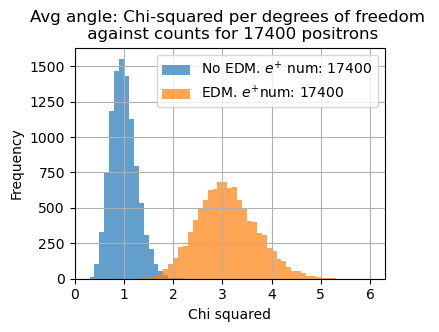

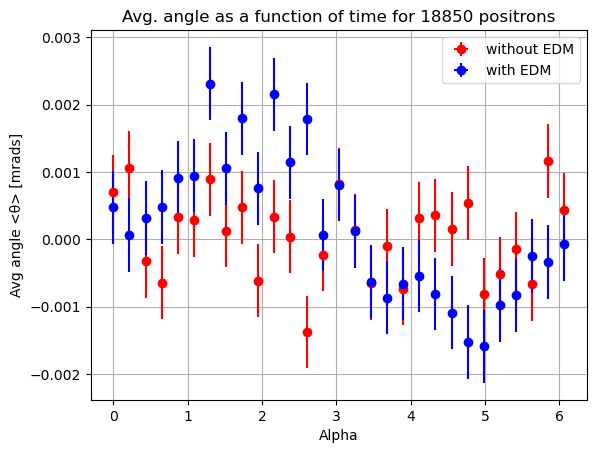

<Figure size 640x480 with 0 Axes>

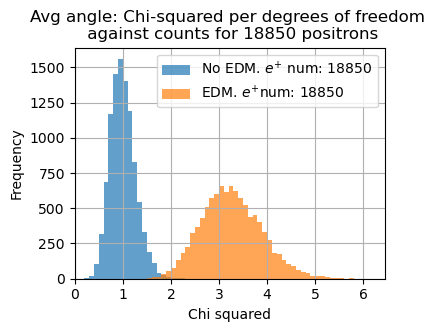

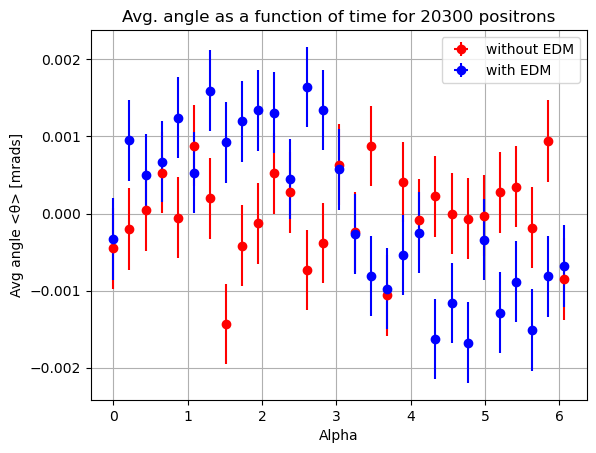

<Figure size 640x480 with 0 Axes>

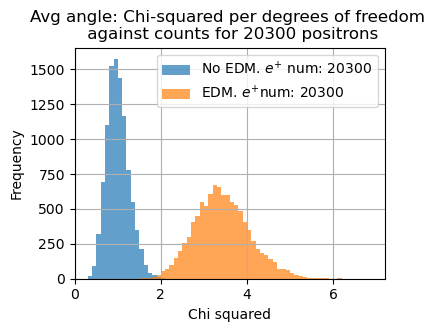

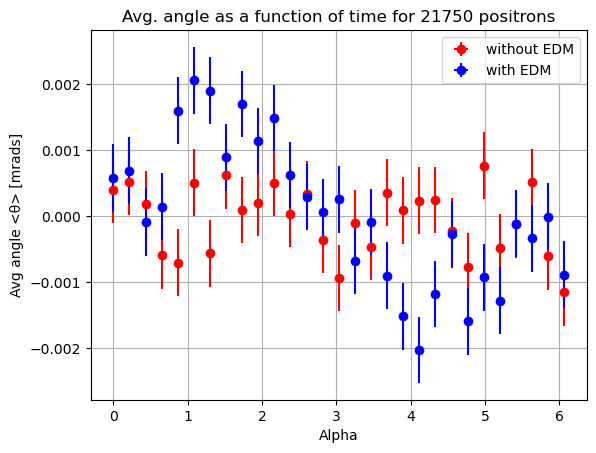

<Figure size 640x480 with 0 Axes>

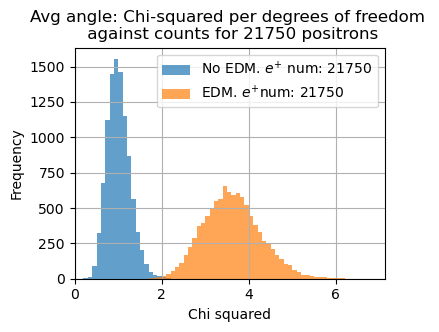

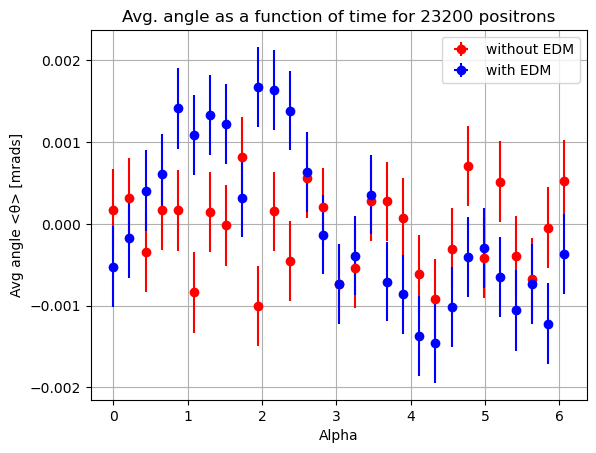

<Figure size 640x480 with 0 Axes>

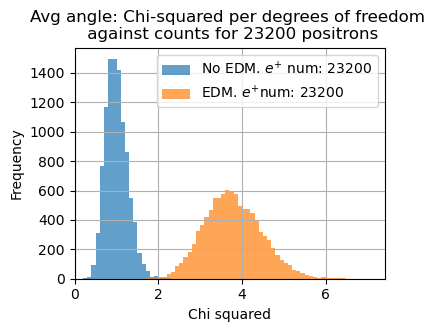

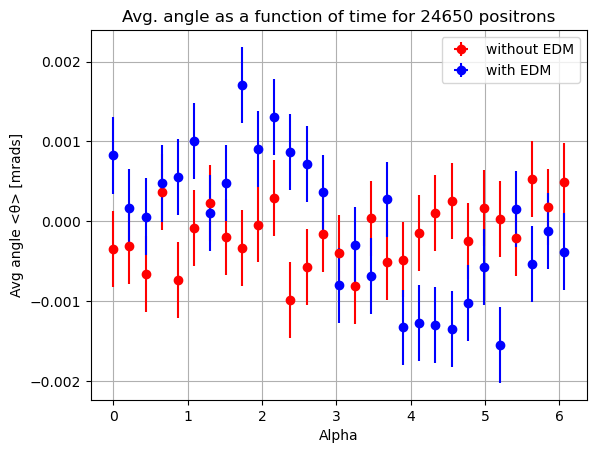

<Figure size 640x480 with 0 Axes>

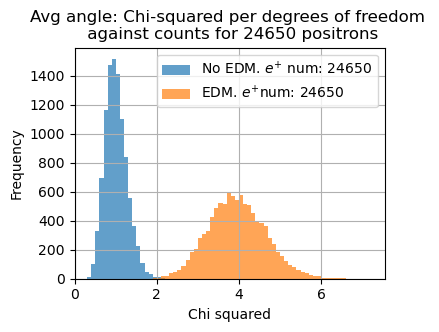

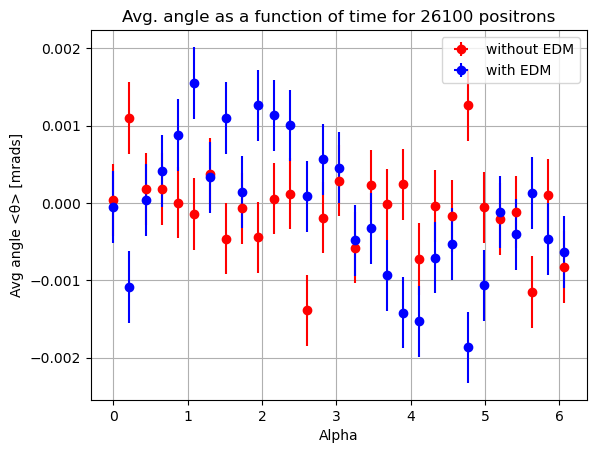

<Figure size 640x480 with 0 Axes>

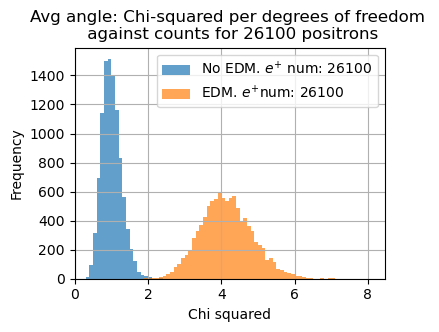

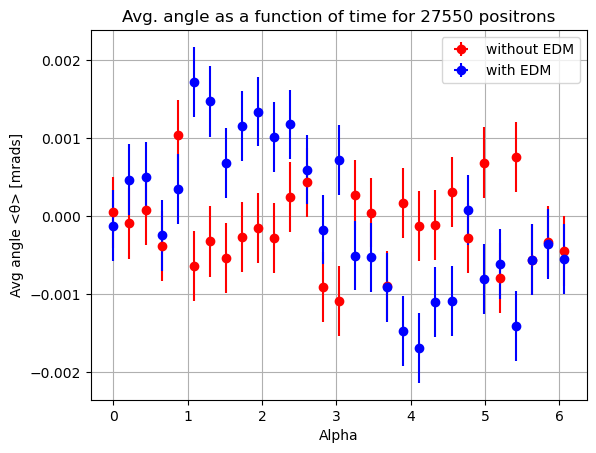

<Figure size 640x480 with 0 Axes>

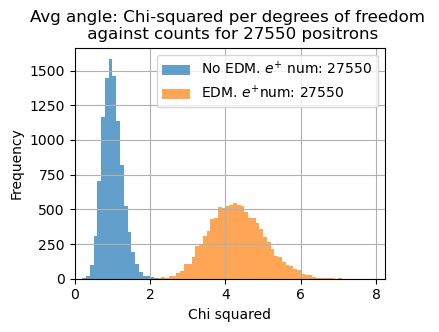

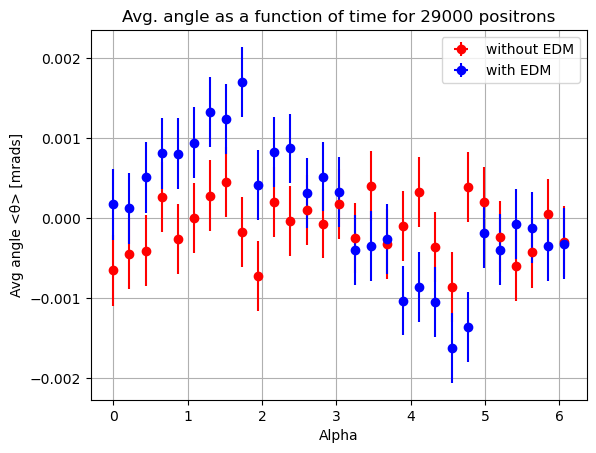

<Figure size 640x480 with 0 Axes>

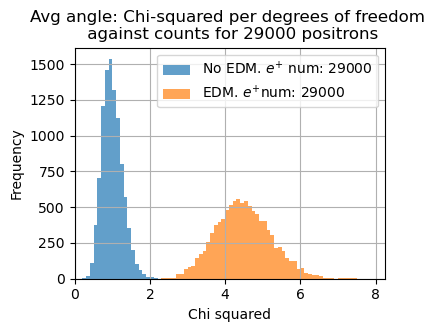

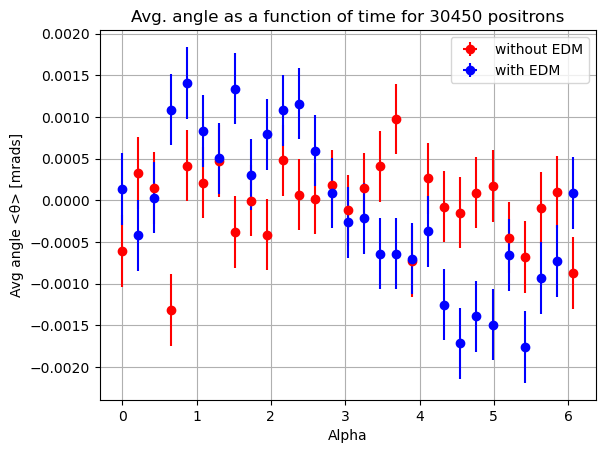

<Figure size 640x480 with 0 Axes>

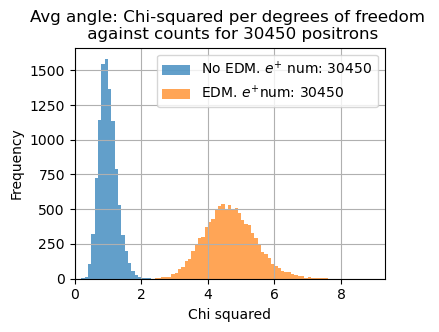

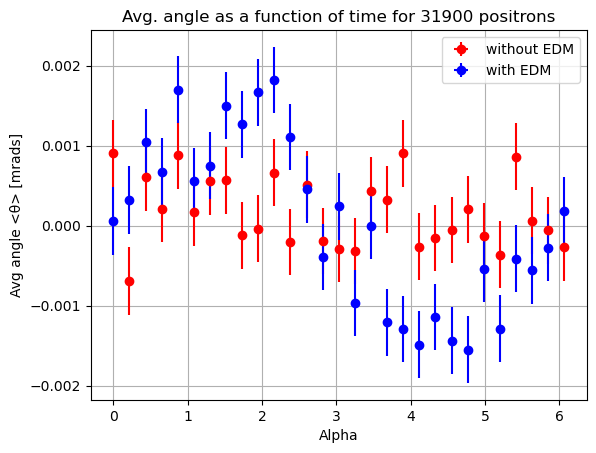

<Figure size 640x480 with 0 Axes>

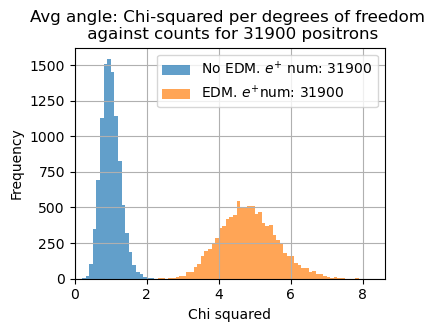

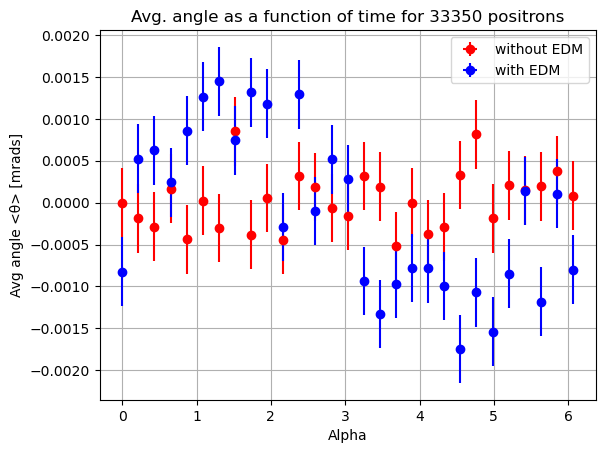

<Figure size 640x480 with 0 Axes>

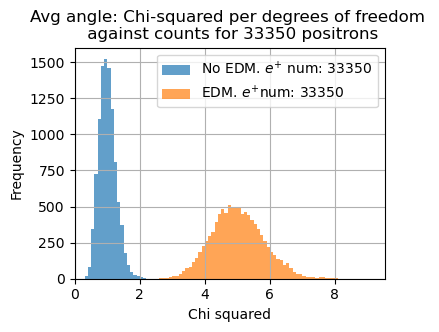

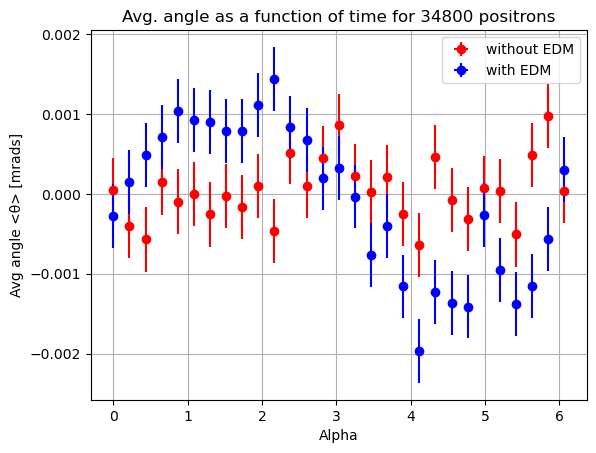

<Figure size 640x480 with 0 Axes>

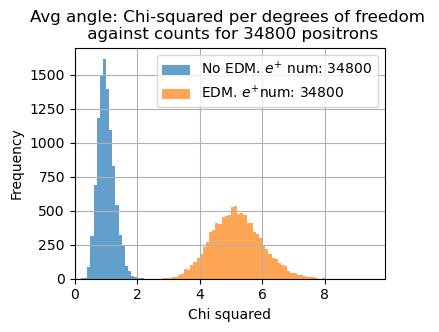

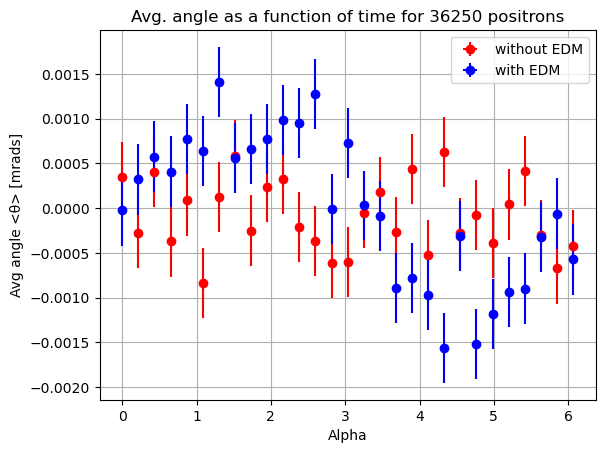

<Figure size 640x480 with 0 Axes>

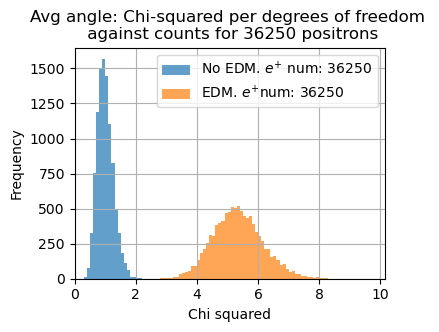

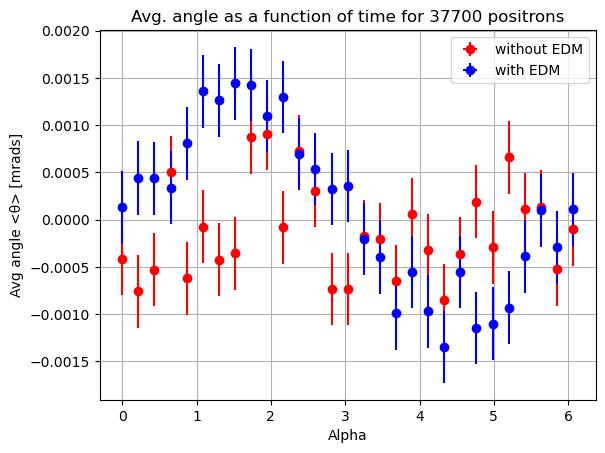

<Figure size 640x480 with 0 Axes>

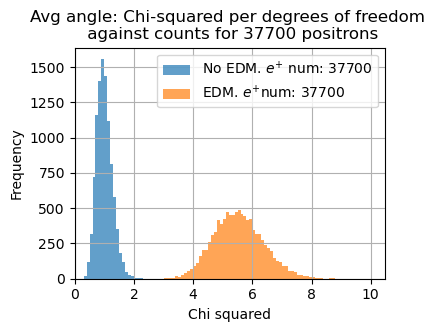

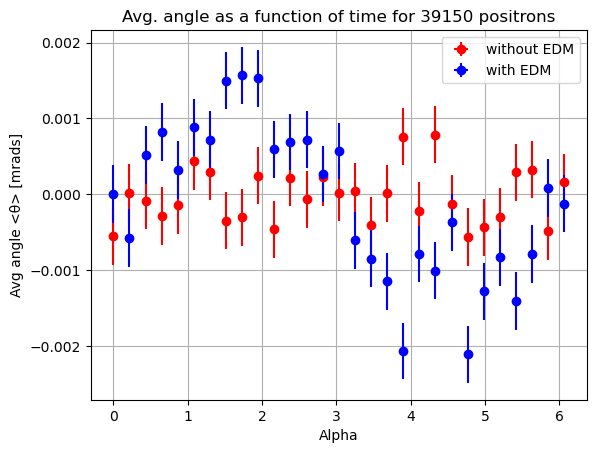

<Figure size 640x480 with 0 Axes>

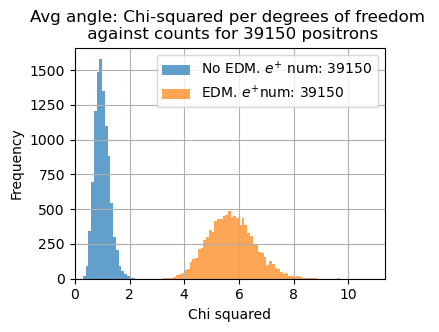

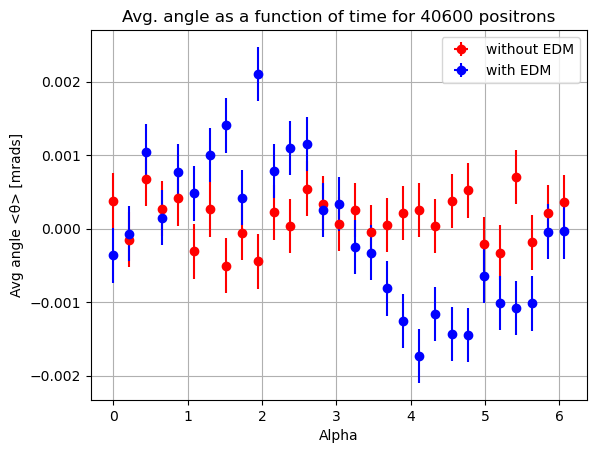

<Figure size 640x480 with 0 Axes>

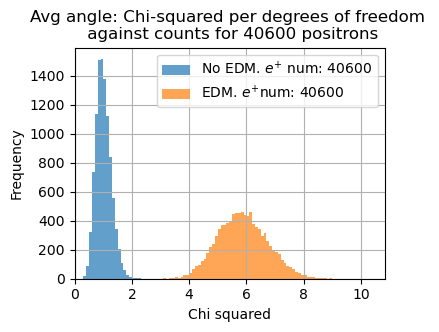

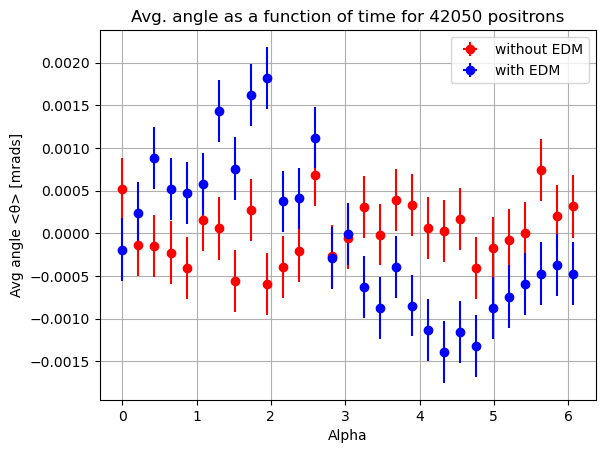

<Figure size 640x480 with 0 Axes>

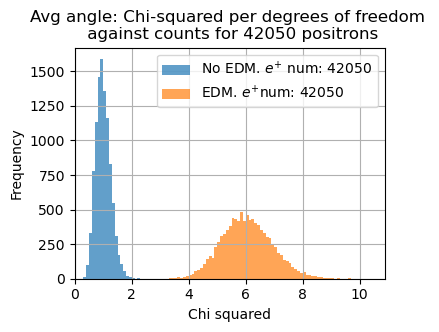

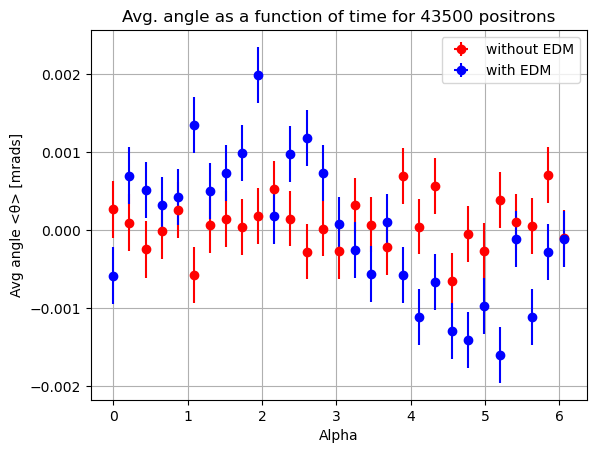

<Figure size 640x480 with 0 Axes>

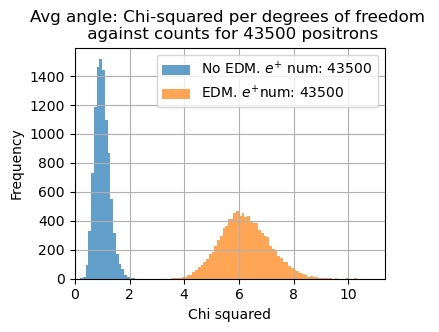

Chi-squared calculations and histograms complete.
[  50  100  150  200  250  300  350  400  450  500  550  600  650  700
  750  800  850  900  950 1000 1050 1100 1150 1200 1250 1300 1350 1400
 1450 1500]
[83.64, 67.24, 46.71, 29.78, 17.8, 10.33, 4.67, 2.5100000000000002, 1.11, 0.44, 0.15, 0.06, 0.02, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
max of 0 is 2.163722871102846


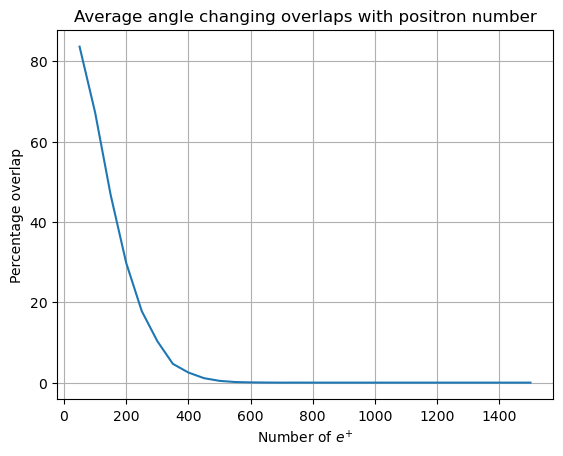

2


In [247]:
# #positrons = np.array([1e2, 1e3, 1e4])#, 1e5, 1e6, 1e7, 1e8, 1e9]) 
# positrons = np.arange([100, 1000, 100])
# positrons = np.array(positrons)
#positrons = np.array([40, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 
                      #1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000])
positrons = (np.arange(50, 1400+150, 50))
positrons = np.array(positrons)
pseudos = int(1e4) 
#edmi = 1

binstmp = np.linspace(0,50, 501)
binstmp = np.array(binstmp)
binwidths = binstmp[1] - binstmp[0]
totaloverlaps1 = []

for i in range(len(positrons)):  
    positron_number = positrons[i]  
    chisq_sums = [[],[]]
    chisq_dofs = [[],[]]

    for n in range(pseudos):
        newthetaerrs, newthetas = randomiseAvg(avgangles, positron_number)
        #newthetaerr = newthetaerrs[edmi]
        #newtheta = newthetas[edmi]
        
        if newthetaerrs is None or newthetas is None:
            print(f"Warning: randomiseAvg returned None for positron level {positron_number*29}, experiment {n}. Skipping.")
            continue  # Skip this pseudo-experiment if there's an issue with randomiseAvg

        newthetaerrs = np.array(newthetaerrs)
        newthetas = np.array(newthetas)
        dof = 29 #is degrees of freedom length of newtheta?

        for edmi in [0,1]:
            chisq_sum = np.sum((newthetas[edmi] ** 2) / (newthetaerrs[edmi] ** 2))
            chisq_dof = chisq_sum/dof
 
            chisq_sums[edmi].append(chisq_sum)
            chisq_dofs[edmi].append(chisq_dof)
        
        plot = ((n >0) and (n % 8000 == 0))
        # use to select which ones to plot
        
        if plot:
            #print(n)
            #print(newthetaerr)
            plt.clf()
            plt.errorbar(phaseval, newthetas[0], xerr=0, yerr=newthetaerrs[0], color='r', 
                         label='without EDM', linestyle='', marker='o')
            plt.errorbar(phaseval, newthetas[1], xerr=0, yerr=newthetaerrs[1], color='b', 
                         label='with EDM', linestyle='', marker='o')
            plt.title(f'Avg. angle as a function of time for {positron_number*29} positrons')
            plt.grid()
            plt.legend()
            plt.ylabel('Avg angle <θ> [mrads]')
            plt.xlabel('Alpha')
            plt.show()
        
    #chisq_mean = np.mean(chisq_sums)
    #chisq_dof_mean = np.mean(chisq_dofs)
    
    #chisq_std = np.std(chisq_sums)
    #chisq_dof_std = np.std(chisq_dofs)

    plt.clf()
    plt.figure(figsize=(4, 3))
    #print(chisq_dofs)
    #plt.hist(chisq_sums, bins=50, alpha=0.7, label=f'Positron number: {positron_number}')
    # for now leave plotting chisq, plot chisq/dof 
    plt.hist(chisq_dofs[0], bins=binstmp, alpha=0.7, label=r'No EDM. $e^{+}$' + f' num: {positron_number*29}')
    plt.hist(chisq_dofs[1], bins=binstmp, alpha=0.7, label=r'EDM. $e^{+}$'+ f'num: {positron_number*29}')
    
    #creating np.histograms to compile data 
    avganglehist1, bins_edges = np.histogram(chisq_dofs[0], bins=binstmp, density=False)
    avganglehist2, _ = np.histogram(chisq_dofs[1], bins=binstmp, density=False)    
    
    #crossover1 = np.minimum(avganglehist1, avganglehist2) * binwidths
    
    # making chisq_dofs into 2 arrays
    
#     avganglearray1 = np.array(chisq_dofs[0])
#     avganglearray2 = np.array(chisq_dofs[1])
    
#     maxblue1 = np.max(avganglearray1[avganglearray1>0])
#     crossover1 = np.sum(avganglearray2[avganglearray2 <= maxblue1])
#     #crossover1 = np.sum(avganglearray2 <= maxblue1)
    
# #     maxblue1 = np.max(chisq_dofs[0][chisq_dofs[0] > 0])
# #     crossover1 = np.sum(chisq_dofs[1][chisq_dofs[1] <= maxblue1])

#     totaloverlap1 = (crossover1 / pseudos)*100
#     totaloverlaps1.append(totaloverlap1)
    
    avgangle1 = np.percentile(chisq_dofs[0], 95)
    avgangle2 = np.percentile(chisq_dofs[1], 95)
    
    crossover1 = np.sum(chisq_dofs[1] < avgangle1)
    totaloverlap1 = (crossover1 / pseudos)*100
    totaloverlaps1.append(totaloverlap1)

    
    #censor below to run faster and get less graphs outputted
    plt.title(f'Avg angle: Chi-squared per degrees of freedom \n against counts for {positron_number*29} positrons')
    plt.xlabel('Chi squared')
    plt.ylabel('Frequency')
    plt.xlim([0, np.max(chisq_dofs[1])*1.1])
    plt.legend()
    plt.grid()
    plt.show()
    #print(f"Completed plotting for positron level {positron_number}.")
    #print(f"Mean for {positron_number} positrons is {chisq_dof_mean:.3f} and standard deviation is {chisq_dof_std:.3f}.")

print("Chi-squared calculations and histograms complete.")

print(positrons)
print(totaloverlaps1)
print('max of 0 is', np.max(chisq_dofs[0]))
plt.plot(positrons, totaloverlaps1)
plt.xlabel(r'Number of $e^{+}$')
plt.ylabel('Percentage overlap')
plt.title('Average angle changing overlaps with positron number')
plt.grid()
plt.show()



print(len(newthetas))

In [248]:
print(totaloverlaps1)
print(positrons*29)

[83.64, 67.24, 46.71, 29.78, 17.8, 10.33, 4.67, 2.5100000000000002, 1.11, 0.44, 0.15, 0.06, 0.02, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[ 1450  2900  4350  5800  7250  8700 10150 11600 13050 14500 15950 17400
 18850 20300 21750 23200 24650 26100 27550 29000 30450 31900 33350 34800
 36250 37700 39150 40600 42050 43500]


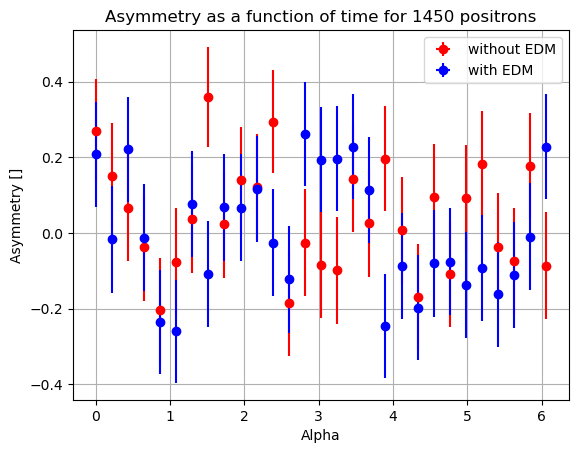

<Figure size 640x480 with 0 Axes>

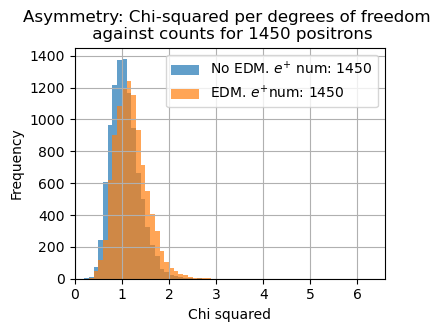

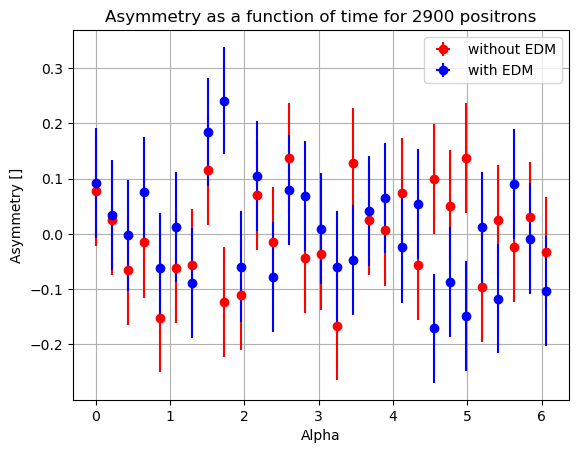

<Figure size 640x480 with 0 Axes>

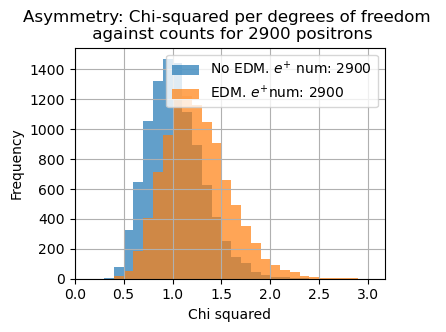

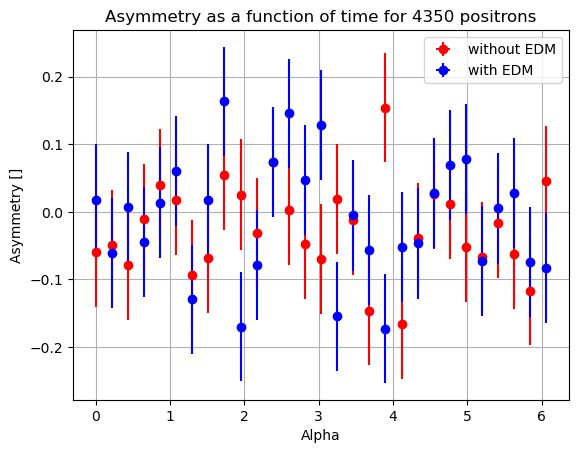

<Figure size 640x480 with 0 Axes>

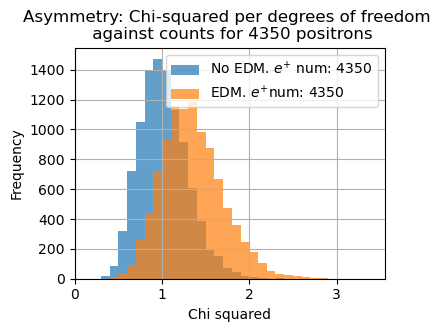

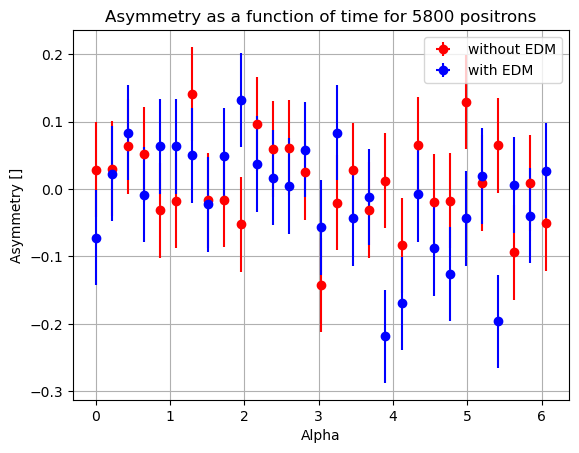

<Figure size 640x480 with 0 Axes>

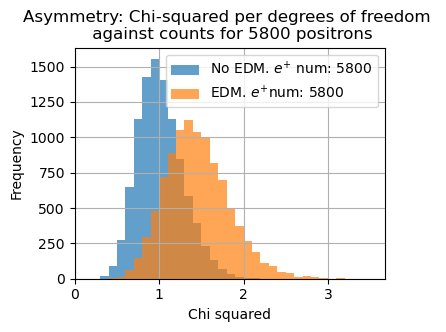

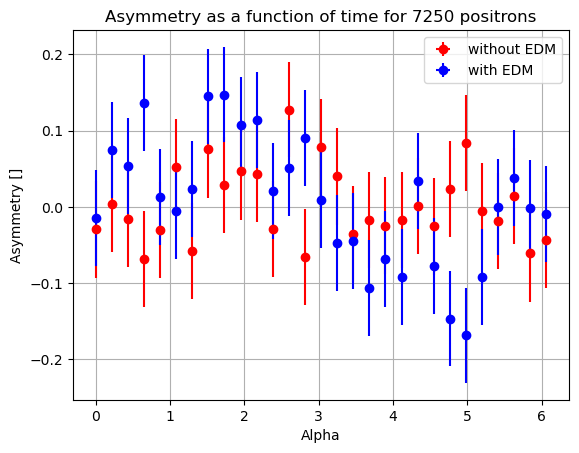

<Figure size 640x480 with 0 Axes>

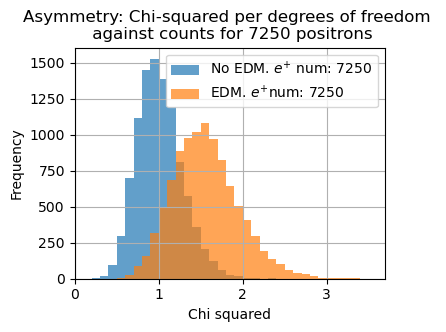

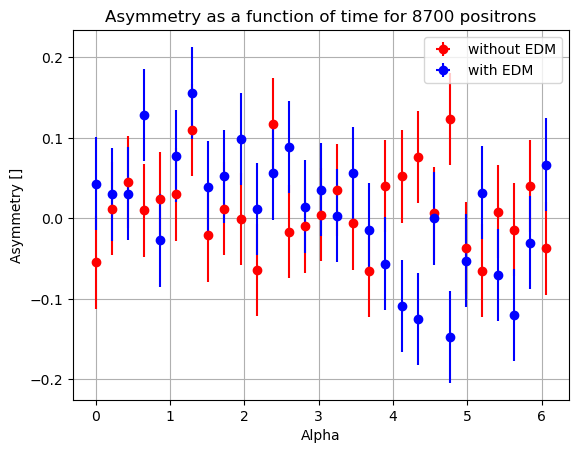

<Figure size 640x480 with 0 Axes>

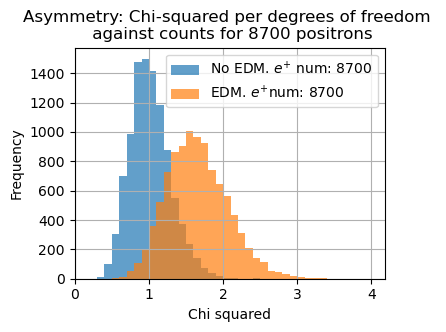

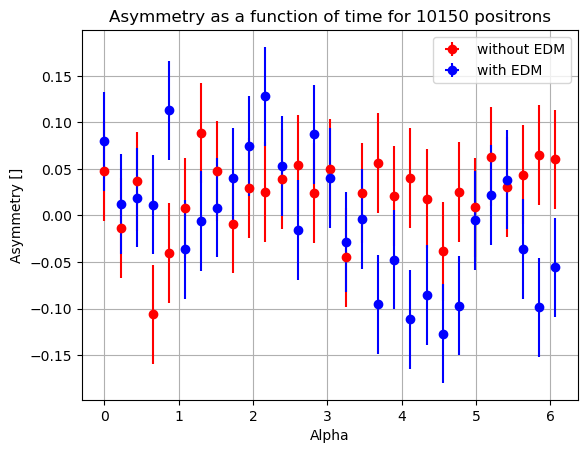

<Figure size 640x480 with 0 Axes>

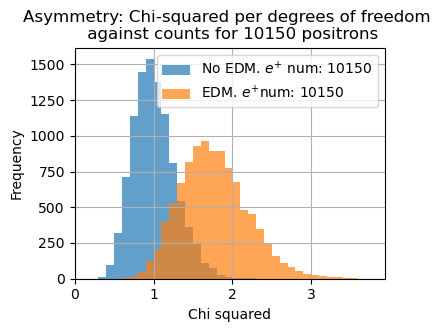

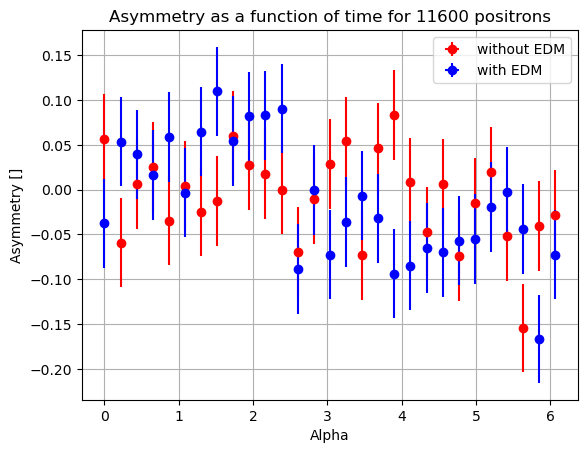

<Figure size 640x480 with 0 Axes>

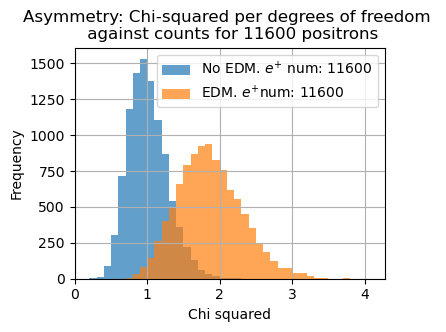

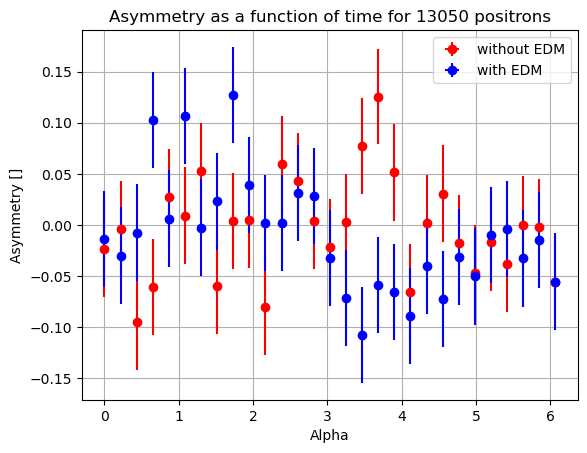

<Figure size 640x480 with 0 Axes>

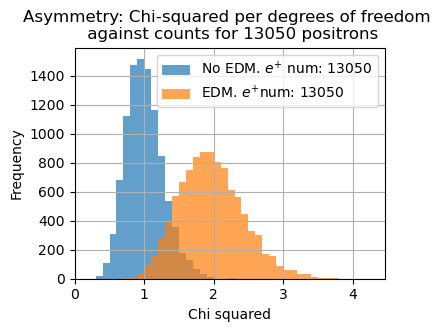

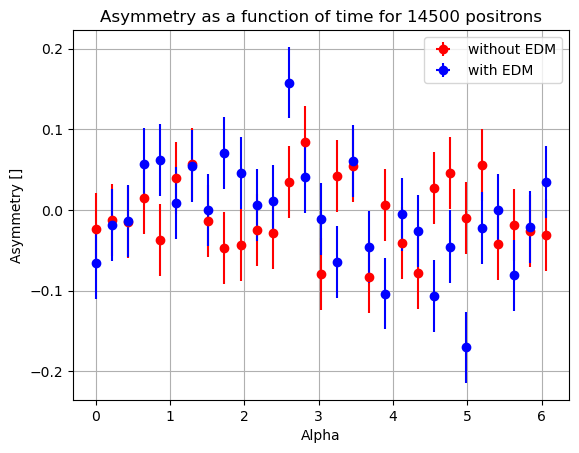

<Figure size 640x480 with 0 Axes>

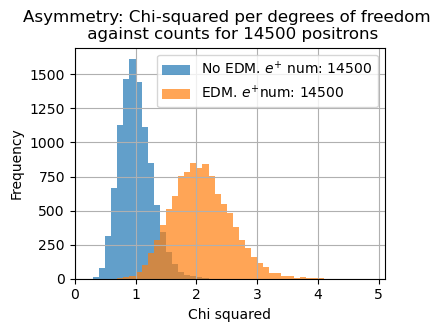

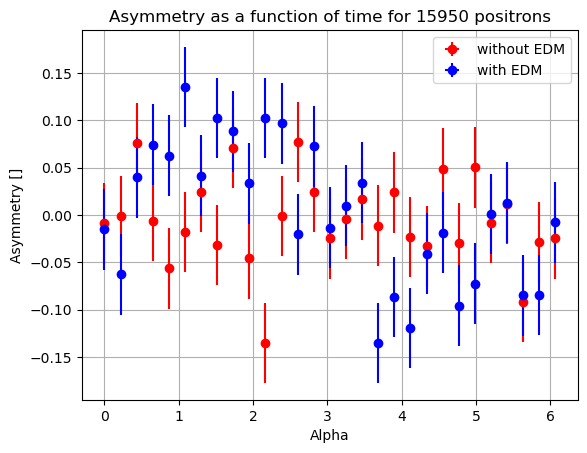

<Figure size 640x480 with 0 Axes>

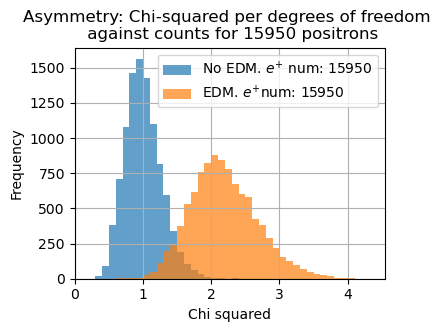

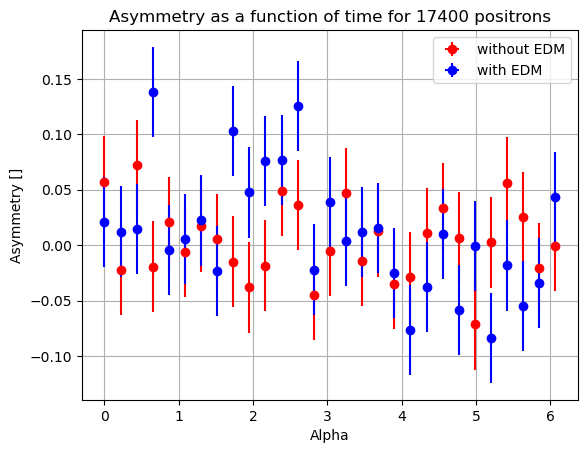

<Figure size 640x480 with 0 Axes>

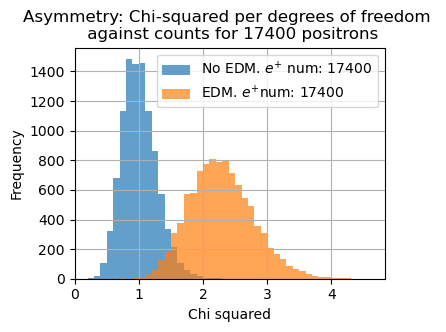

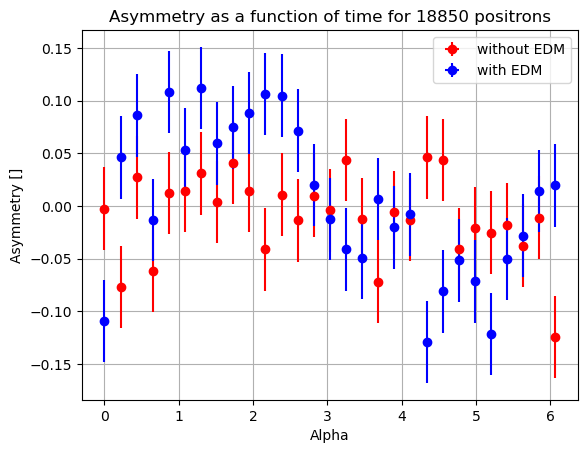

<Figure size 640x480 with 0 Axes>

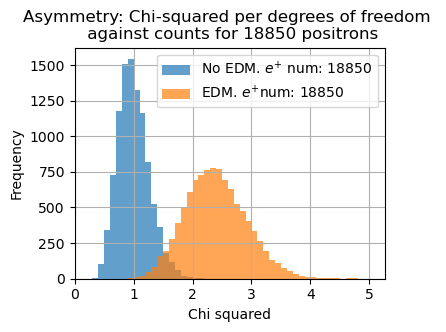

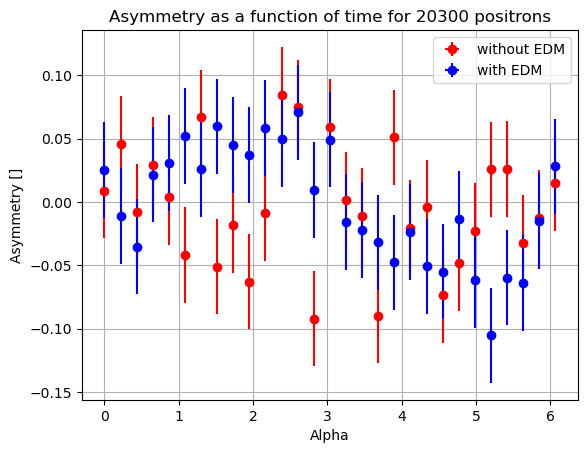

<Figure size 640x480 with 0 Axes>

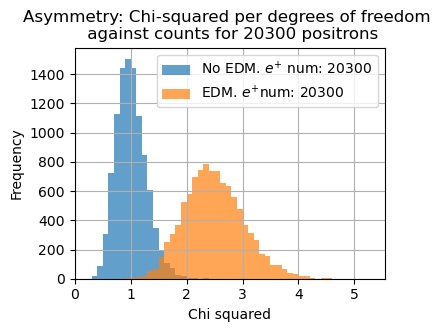

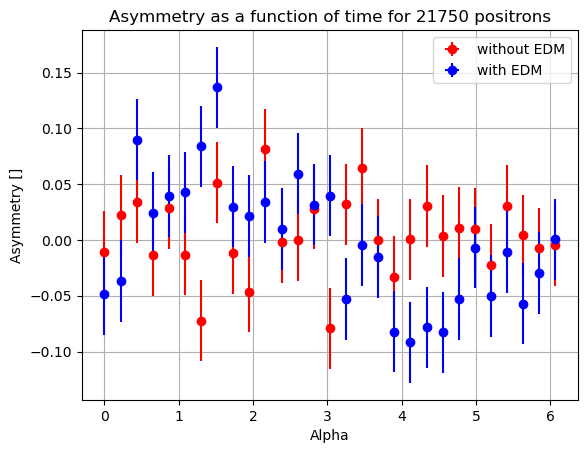

<Figure size 640x480 with 0 Axes>

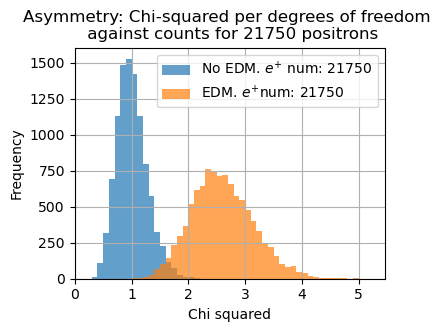

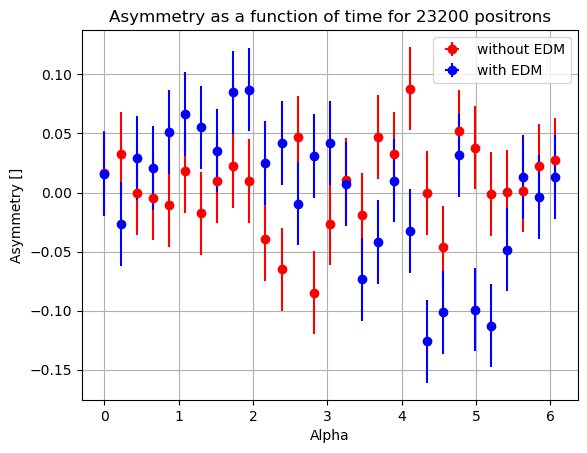

<Figure size 640x480 with 0 Axes>

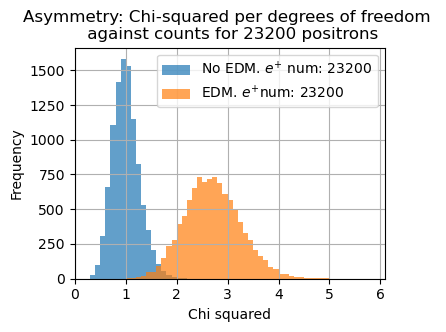

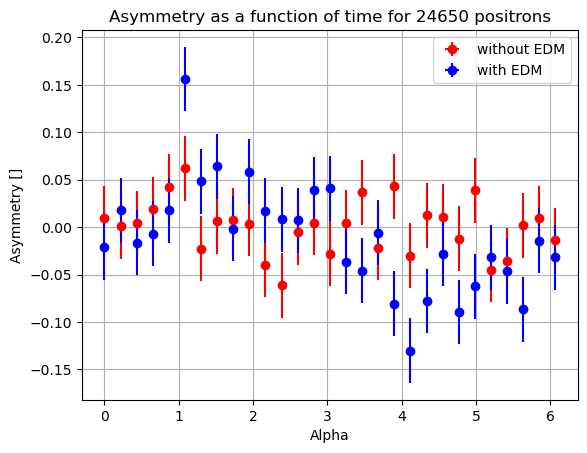

<Figure size 640x480 with 0 Axes>

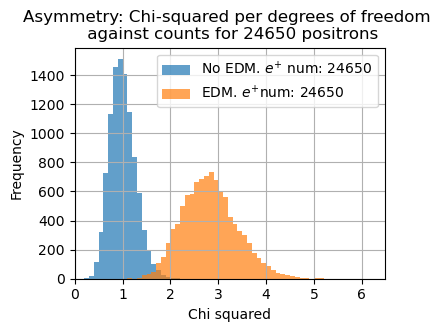

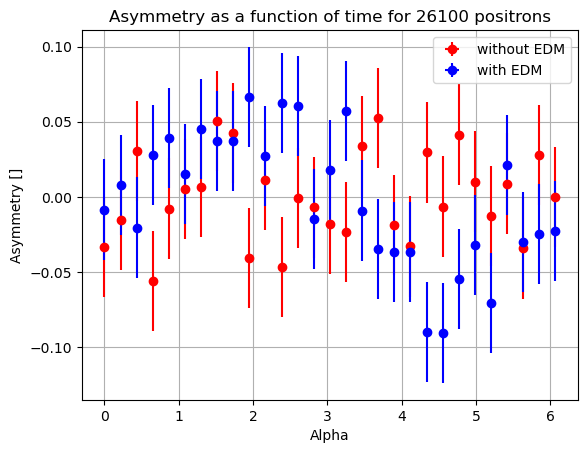

<Figure size 640x480 with 0 Axes>

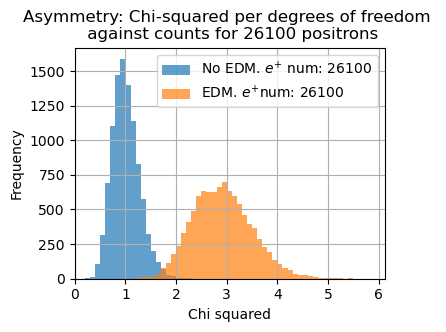

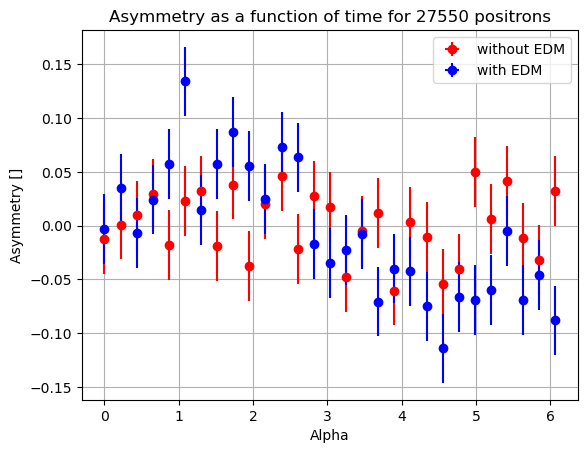

<Figure size 640x480 with 0 Axes>

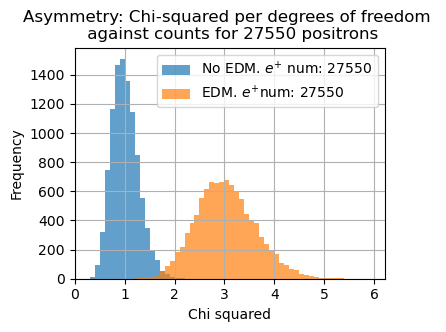

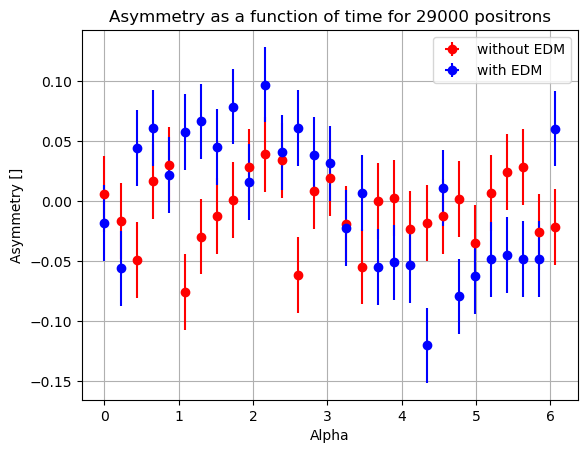

<Figure size 640x480 with 0 Axes>

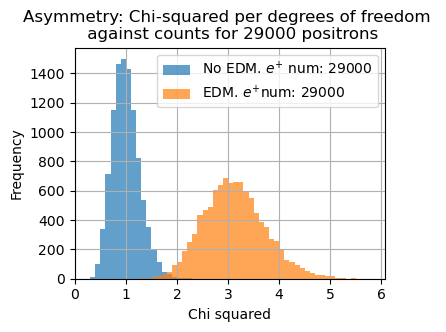

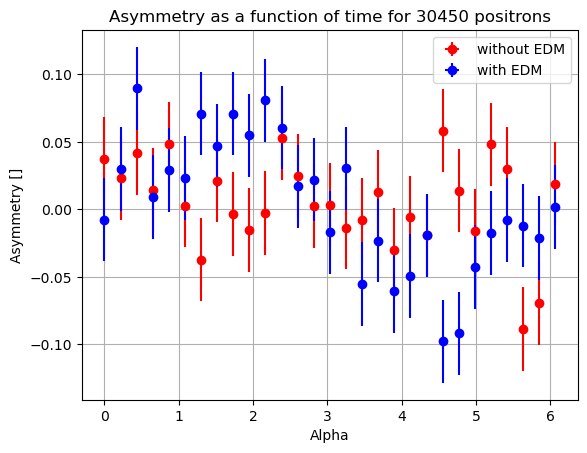

<Figure size 640x480 with 0 Axes>

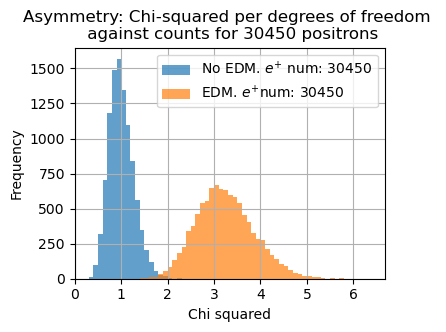

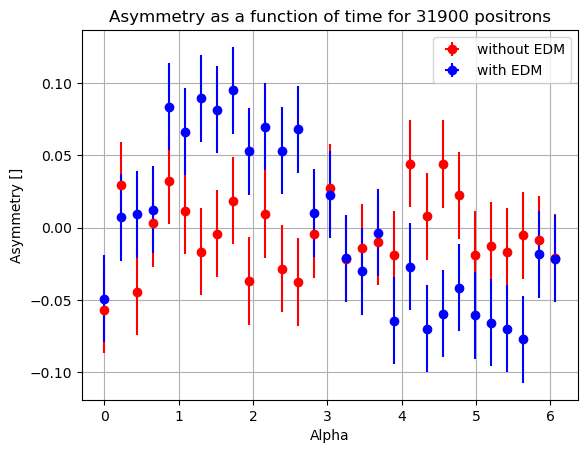

<Figure size 640x480 with 0 Axes>

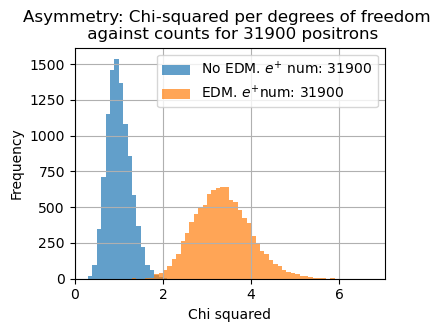

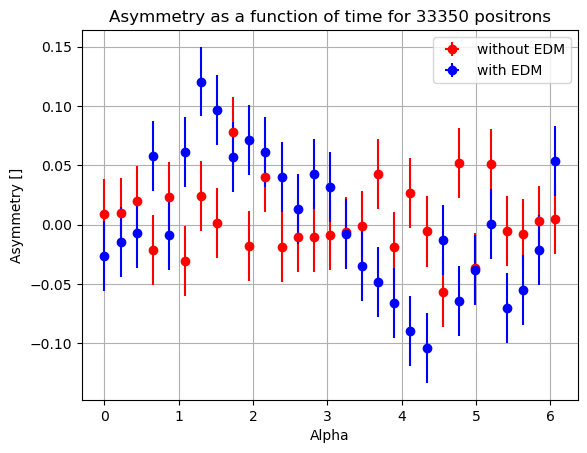

<Figure size 640x480 with 0 Axes>

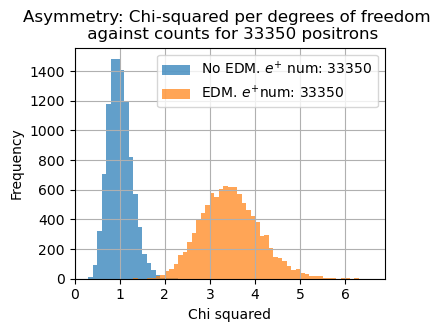

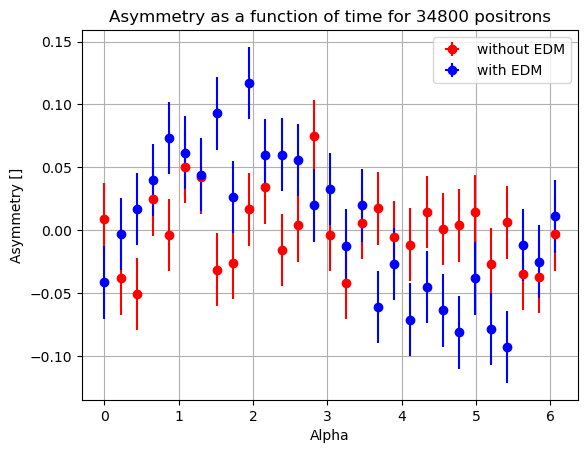

<Figure size 640x480 with 0 Axes>

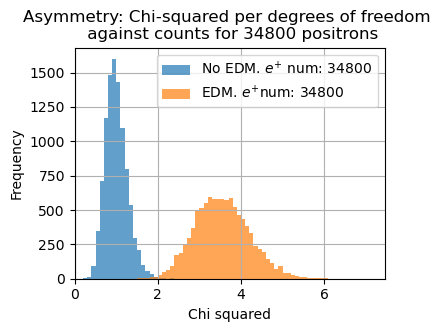

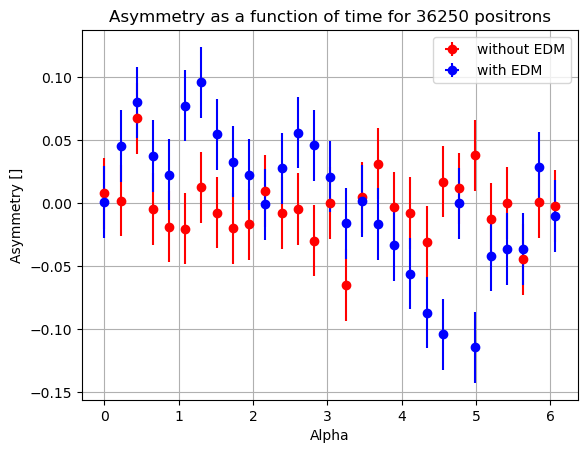

<Figure size 640x480 with 0 Axes>

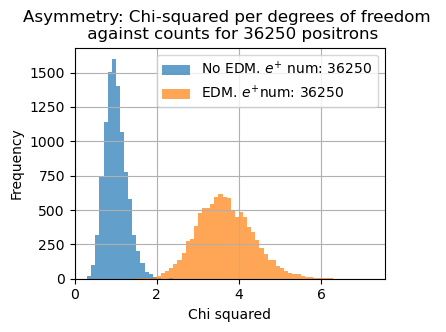

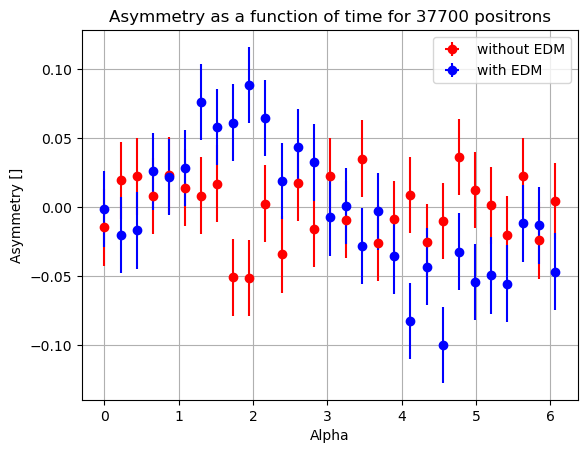

<Figure size 640x480 with 0 Axes>

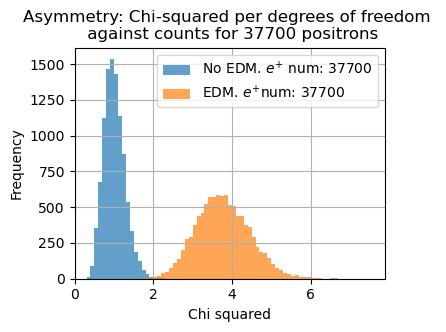

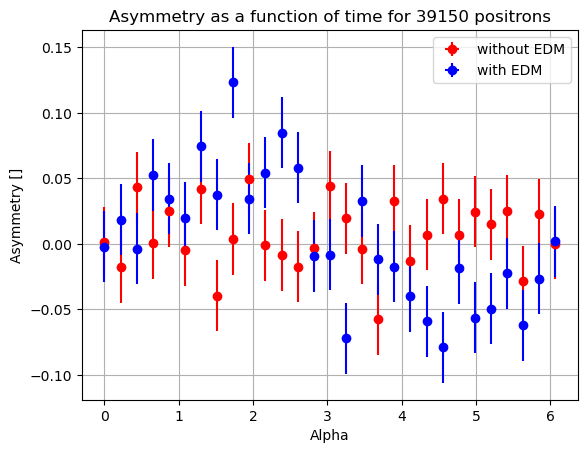

<Figure size 640x480 with 0 Axes>

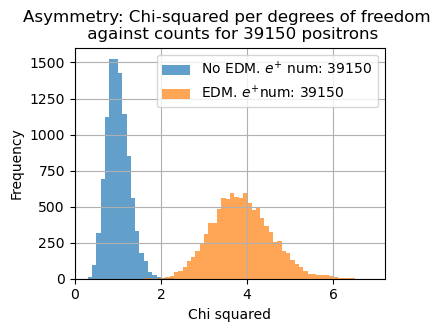

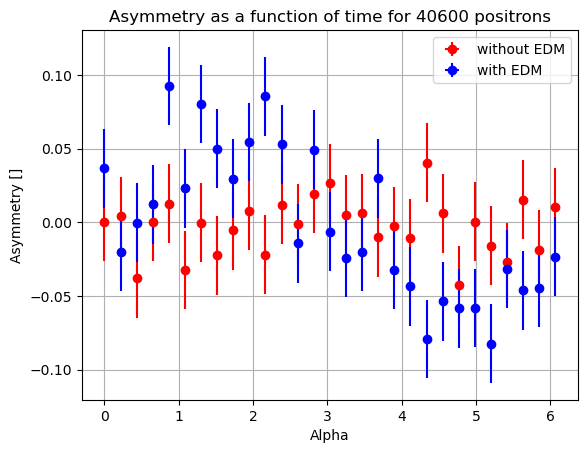

<Figure size 640x480 with 0 Axes>

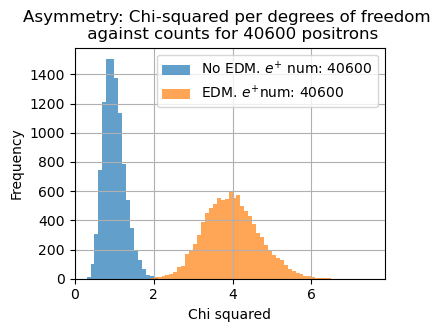

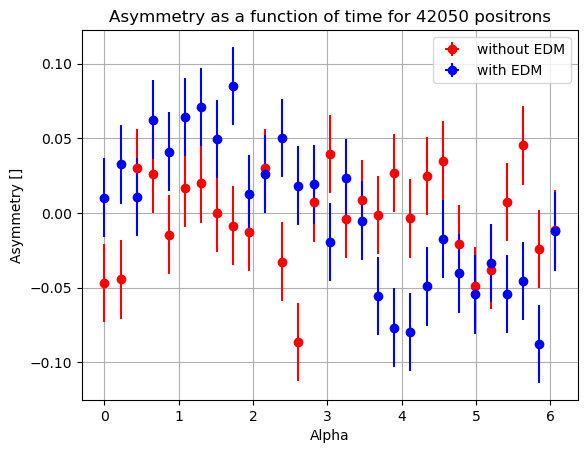

<Figure size 640x480 with 0 Axes>

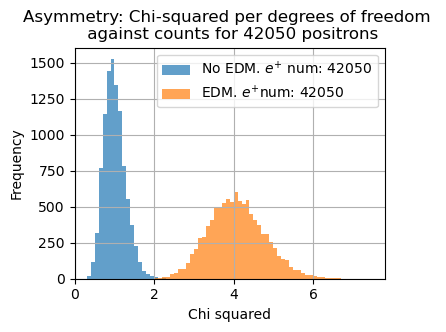

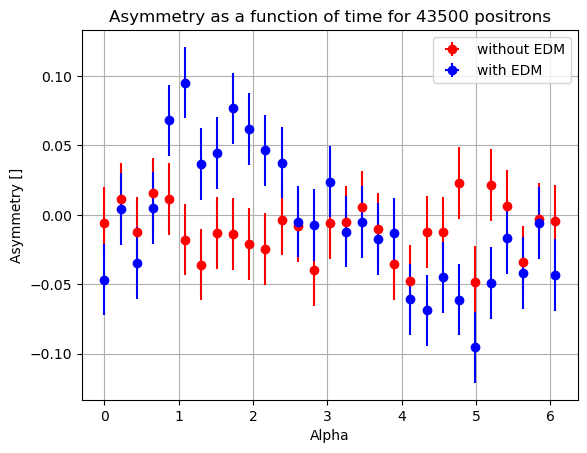

<Figure size 640x480 with 0 Axes>

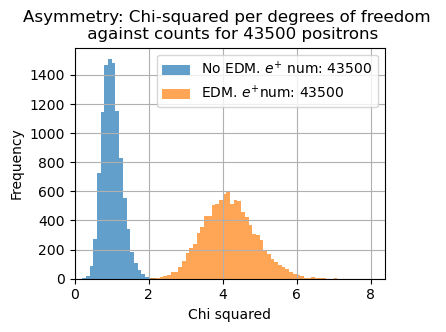

Chi-squared calculations and histograms complete.
[88.44999999999999, 80.85, 69.49, 57.92, 45.129999999999995, 38.37, 27.52, 20.18, 13.94, 9.41, 5.609999999999999, 3.8, 2.5, 1.4200000000000002, 1.11, 0.6, 0.32, 0.2, 0.12, 0.03, 0.05, 0.03, 0.02, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0]


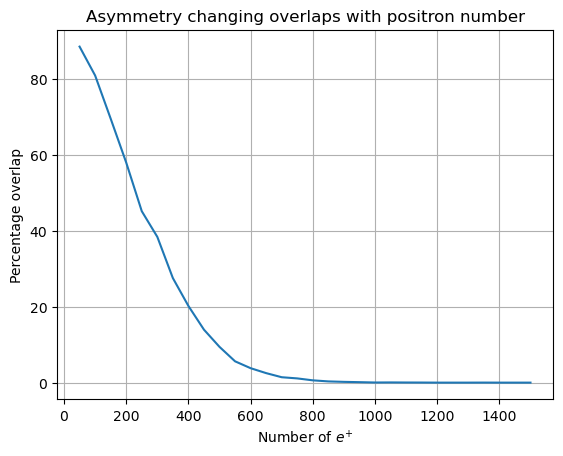

In [249]:
# all the same for asymmetry now.

# positrons = np.array([1e2, 1e3, 1e4])#, 1e5, 1e6, 1e7, 1e8, 1e9]) 
# positrons = np.array([40, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 
#                       1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000])
pseudos = int(1e4) 
#edmi = 1

binstmp = np.linspace(0,50, 501)
binstmp = np.array(binstmp)
binwidths = binstmp[1] - binstmp[0]
totaloverlaps2  = []

for i in range(len(positrons)):  
    positron_number = positrons[i]  
    chisq_sums2 = [[],[]]
    chisq_dofs2 = [[],[]]

    for n in range(pseudos):
        newasymerrs, newasyms = randomiseA(Asym, positron_number)
        #newthetaerr = newthetaerrs[edmi]
        #newtheta = newthetas[edmi]
        
        if newasymerrs is None or newasyms is None:
            print(f"Warning: randomiseAsym returned None for positron level {positron_number*29}, experiment {n}. Skipping.")
            continue  # Skip this pseudo-experiment if there's an issue with randomiseAvg
        
        newasymerrs = np.array(newasymerrs)
        newasyms = np.array(newasyms)
        dof = 29 #is degrees of freedom length of newtheta?

        for edmi in [0,1]:
            chisq_sum2 = np.sum((newasyms[edmi] ** 2) / (newasymerrs[edmi] ** 2))
            chisq_dof2 = chisq_sum2/dof
 
            chisq_sums2[edmi].append(chisq_sum2)
            chisq_dofs2[edmi].append(chisq_dof2)
        
        plot = ((n >0) and (n % 8000 == 0))
        # use to select which ones to plot??? help 
        
        if plot:
            #print(n)
            #print(newthetaerr)
            plt.clf()
            plt.errorbar(phaseval, newasyms[0], xerr=0, yerr=newasymerrs[0], color='r', 
                         label='without EDM', linestyle='', marker='o')
            plt.errorbar(phaseval, newasyms[1], xerr=0, yerr=newasymerrs[1], color='b', 
                         label='with EDM', linestyle='', marker='o')
            plt.title(f'Asymmetry as a function of time for {positron_number*29} positrons')
            plt.grid()
            plt.legend()
            plt.ylabel('Asymmetry []')
            plt.xlabel('Alpha')
            plt.show()
        
    #chisq_mean = np.mean(chisq_sums)
    #chisq_dof_mean = np.mean(chisq_dofs)
    
    #chisq_std = np.std(chisq_sums)
    #chisq_dof_std = np.std(chisq_dofs)

    plt.clf()
    plt.figure(figsize=(4, 3))
    #print(chisq_dofs)
    #plt.hist(chisq_sums, bins=50, alpha=0.7, label=f'Positron number: {positron_number}')
    # for now leave plotting chisq, plot chisq/dof 
    plt.hist(chisq_dofs2[0], bins=binstmp, alpha=0.7, label=r'No EDM. $e^{+}$' + f' num: {positron_number*29}')
    plt.hist(chisq_dofs2[1], bins=binstmp, alpha=0.7, label=r'EDM. $e^{+}$'+ f'num: {positron_number*29}')
    
    asymhist1, bins_edges = np.histogram(chisq_dofs2[0], bins=binstmp, density=False)
    asymhist2, _ = np.histogram(chisq_dofs2[1], bins=binstmp, density=False)
    
#     crossover2 = np.minimum(asymhist1, asymhist2) * binwidths
#     totaloverlap2 = np.sum(crossover2)
#     totaloverlaps2.append(totaloverlap2)

    # making chisq_dofs into 2 arrays
    
#     asymarray1 = np.array(chisq_dofs2[0])
#     asymarray2 = np.array(chisq_dofs2[1])
    
#     maxblue2 = np.max(asymarray1[asymarray1>0])
#     crossover2 = asymarray2[asymarray2 <= maxblue2]
#     #crossover2 = np.sum(asymarray2 <= maxblue2)
    
#     maxblue1 = np.max(chisq_dofs[0][chisq_dofs[0] > 0])
#     crossover1 = np.sum(chisq_dofs[1][chisq_dofs[1] <= maxblue1])

    asymarray1 = np.percentile(chisq_dofs2[0], 95)
    asymarray2 = np.percentile(chisq_dofs2[1], 95)
    
    crossover2 = np.sum(chisq_dofs2[1] < asymarray1)
    totaloverlap2 = (crossover2 / pseudos)*100
    totaloverlaps2.append(totaloverlap2)
    
    plt.title(f'Asymmetry: Chi-squared per degrees of freedom \n against counts for {positron_number*29} positrons')
    plt.xlabel('Chi squared')
    plt.ylabel('Frequency')
    plt.xlim([0, np.max(chisq_dofs2[1])*1.1])
    plt.legend()
    plt.grid()
    plt.show()

    #print(f"Completed plotting for positron level {positron_number}.")
    #print(f"Mean for {positron_number} positrons is {chisq_dof_mean:.3f} and standard deviation is {chisq_dof_std:.3f}.")

print("Chi-squared calculations and histograms complete.")

plt.plot(positrons, totaloverlaps2)
plt.xlabel(r'Number of $e^{+}$')
plt.ylabel('Percentage overlap')
plt.grid()
plt.title('Asymmetry changing overlaps with positron number')

print(totaloverlaps2)

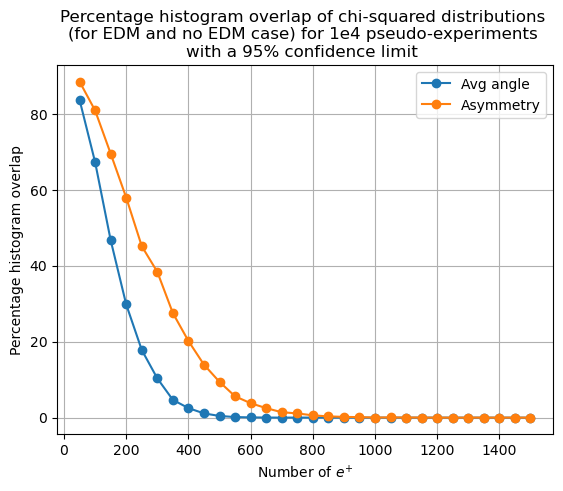

[83.64, 67.24, 46.71, 29.78, 17.8, 10.33, 4.67, 2.5100000000000002, 1.11, 0.44, 0.15, 0.06, 0.02, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[  50  100  150  200  250  300  350  400  450  500  550  600  650  700
  750  800  850  900  950 1000 1050 1100 1150 1200 1250 1300 1350 1400
 1450 1500]
[88.44999999999999, 80.85, 69.49, 57.92, 45.129999999999995, 38.37, 27.52, 20.18, 13.94, 9.41, 5.609999999999999, 3.8, 2.5, 1.4200000000000002, 1.11, 0.6, 0.32, 0.2, 0.12, 0.03, 0.05, 0.03, 0.02, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0]


In [250]:
# finding this overlap
# how signal-like does the non-EDM case look?
# end goal is a plot of N positrons against overlap (%)

plt.plot(positrons, totaloverlaps1, label='Avg angle', marker='o')
plt.plot(positrons, totaloverlaps2, label='Asymmetry', marker='o')
plt.legend()
plt.xlabel(r'Number of $e^{+}$')
plt.ylabel('Percentage histogram overlap')
plt.title('Percentage histogram overlap of chi-squared distributions \n(for EDM and no EDM case) for 1e4 pseudo-experiments \nwith a 95% confidence limit ')
plt.grid()
plt.show()

print(totaloverlaps1)
print(positrons)
print(totaloverlaps2)

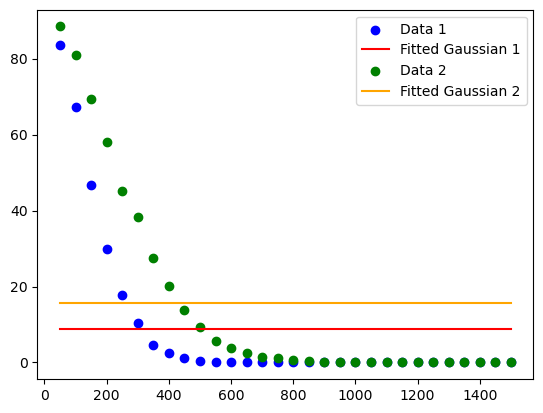

30 30 0.0
Parameter uncertainties 1: [inf inf inf inf]
Parameter uncertainties 2: [inf inf inf inf]


In [251]:
from scipy.optimize import curve_fit
def gaussian(x, A, sigma, x0, C):
    return A * np.exp(-((x-x0)**2) / (2*sigma**2)) + C

params1, covariance1 = curve_fit(gaussian, positrons, totaloverlaps1, p0=[90, 2, 5, 65])
params2, covariance2 = curve_fit(gaussian, positrons, totaloverlaps2, p0=[90, 2, 5, 65])

A_opt1, sigma_opt1, x0_opt1, C_opt1 = params1
A_opt2, sigma_opt2, x0_opt2, C_opt2 = params2

y_fit1 = gaussian(positrons, *params1)
y_fit2 = gaussian(positrons, *params2)


plt.scatter(positrons, totaloverlaps1, label='Data 1', color='blue')
plt.plot(positrons, y_fit1, label='Fitted Gaussian 1', color='red')

plt.scatter(positrons, totaloverlaps2, label='Data 2', color='green')
plt.plot(positrons, y_fit2, label='Fitted Gaussian 2', color='orange')

plt.legend()
plt.show()

print(len(y_fit1), len(positrons), (totaloverlap1))

uncertainties1 = np.sqrt(np.diag(covariance1))
uncertainties2 = np.sqrt(np.diag(covariance2))

print("Parameter uncertainties 1:", uncertainties1)
print("Parameter uncertainties 2:", uncertainties2)

In [252]:
import numpy as np
positrons = (np.arange(50, 1400+150, 50))
positrons = np.array(positrons)
print(positrons, len(positrons))


[  50  100  150  200  250  300  350  400  450  500  550  600  650  700
  750  800  850  900  950 1000 1050 1100 1150 1200 1250 1300 1350 1400
 1450 1500] 30


In [253]:
print('positrons array:', positrons)
print('totaloverlaps1 array:', totaloverlaps1)
print('totaloverlaps 2 array:', totaloverlaps2)

positrons array: [  50  100  150  200  250  300  350  400  450  500  550  600  650  700
  750  800  850  900  950 1000 1050 1100 1150 1200 1250 1300 1350 1400
 1450 1500]
totaloverlaps1 array: [83.64, 67.24, 46.71, 29.78, 17.8, 10.33, 4.67, 2.5100000000000002, 1.11, 0.44, 0.15, 0.06, 0.02, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
totaloverlaps 2 array: [88.44999999999999, 80.85, 69.49, 57.92, 45.129999999999995, 38.37, 27.52, 20.18, 13.94, 9.41, 5.609999999999999, 3.8, 2.5, 1.4200000000000002, 1.11, 0.6, 0.32, 0.2, 0.12, 0.03, 0.05, 0.03, 0.02, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0]


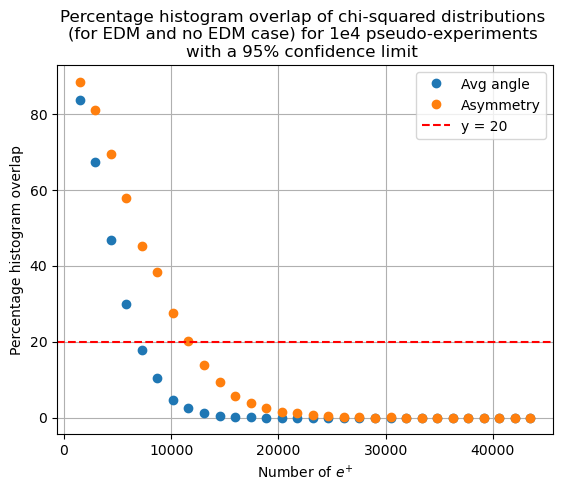

In [254]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


# Define the Gaussian function to fit the data
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Define the exponential decay function to fit the data
def exp_decay(x, A, tau):
    #scipy.special.erf()
    return A * np.exp(-x / tau)

# Plot the original data
plt.plot(positrons*29, totaloverlaps1, label='Avg angle', marker='o', linestyle='')
plt.plot(positrons*29, totaloverlaps2, label='Asymmetry', marker='o', linestyle='')


# Plot the exponential decay curves
y_fit1_exp = exp_decay(x_fit, *params1_exp)
y_fit2_exp = exp_decay(x_fit, *params2_exp)


# plt.plot(x_fit, y_fit1_exp, label='Fit 1 (Avg angle)', linestyle=':')
# plt.plot(x_fit, y_fit2_exp, label='Fit 2 (Asymmetry)', linestyle=':')

# Plot the exponential decay curves
xtmp=np.linspace(positrons[0], 1500*29, 5000)
y_fit1_erf = np.interp(xtmp, positrons*29, totaloverlaps1)
y_fit2_erf = np.interp(xtmp, positrons*29, totaloverlaps2)
#plt.plot(xtmp, y_fit1_erf, label='Fit 1 (Avg angle)', linestyle='--')
#plt.plot(xtmp, y_fit2_erf, label='Fit 2 (Asymmetry)', linestyle='--')

# Find the intersections with y = 20 for both fits (using exponential for now)
# def find_intersections_exp(fit_params, target_y=20):
#     A, tau = fit_params
#     # Solving for x when y = 20: 20 = A * exp(-x / tau)
#     # Rearranging: x = -tau * np.log(20 / A)
#     x = -tau * np.log(target_y / A)
#     return x

# # Find intersections for the exponential decay fits
# x_intersect1_exp = find_intersections_exp(params1_exp)
# x_intersect2_exp = find_intersections_exp(params2_exp)

# # Plot the intersections
# plt.scatter([x_intersect1_exp], [20], color='blue', zorder=5)
# plt.scatter([x_intersect2_exp], [20], color='green', zorder=5)

# # Print the intersections for the exponential fits
# print(f"Intersection point for first curve (Avg angle) using exponential: x = {x_intersect1_exp}")
# print(f"Intersection point for second curve (Asymmetry) using exponential: x = {x_intersect2_exp}")


# Label the plot
plt.axhline(y=20, color='r', linestyle='--', label="y = 20")
plt.legend()
plt.xlabel(r'Number of $e^{+}$')
plt.ylabel('Percentage histogram overlap')
plt.title('Percentage histogram overlap of chi-squared distributions \n(for EDM and no EDM case) for 1e4 pseudo-experiments \nwith a 95% confidence limit ')
plt.grid()
plt.show()


Crossings for Fit 1 (Avg angle) at y=20: [6983.722871452421]
Crossings for Fit 2 (Asymmetry) at y=20: [11641.826923076924]


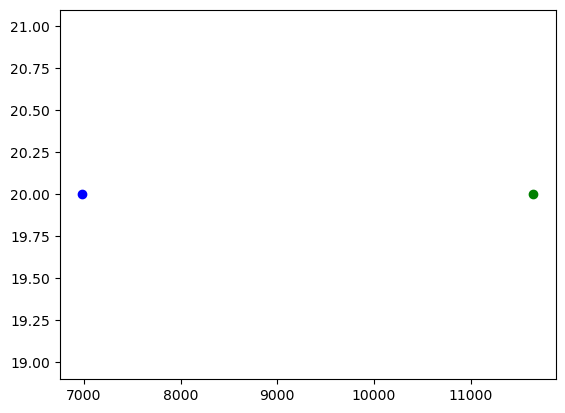

In [255]:
# Function to find the x-value where the curve crosses y=20
def find_x_for_y(xtmp, y_interp, target_y=20):
    # Find the indices where the curve crosses target_y
    indices = np.where(np.diff(np.sign(y_interp - target_y)))[0]
    x_crossings = []

    for i in indices:
        # Linear interpolation between points i and i+1
        x0, x1 = xtmp[i], xtmp[i+1]
        y0, y1 = y_interp[i], y_interp[i+1]
        
        # Avoid division by zero
        if y1 != y0:
            x_cross = x0 + (target_y - y0) * (x1 - x0) / (y1 - y0)
            x_crossings.append(x_cross)

    return x_crossings

# Find the x-values where y = 20
x_crossings1 = find_x_for_y(xtmp, y_fit1_erf, target_y=20)
x_crossings2 = find_x_for_y(xtmp, y_fit2_erf, target_y=20)

# Plot those points
for x in x_crossings1:
    plt.scatter([x], [20], color='blue', zorder=5)

for x in x_crossings2:
    plt.scatter([x], [20], color='green', zorder=5)

# Print results
print(f"Crossings for Fit 1 (Avg angle) at y=20: {x_crossings1}")
print(f"Crossings for Fit 2 (Asymmetry) at y=20: {x_crossings2}")
